In [2]:
#Para uma explicação detalhada sobre esse projeto, visite 
#meu portfolio em: https://henriquelucasdf.github.io/post/projeto1/

# 0.0 CONFIGURAÇÕES INICIAIS

### 0.1 Montando o Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0.2. Instalação de bibliotecas

In [2]:
!pip install inflection
!pip install dython
!pip install boruta
!pip install scikit-optimize

     |████████████████████████████████| 61kB 1.9MB/s 


### 0.3 Importação de Bibliotecas

In [3]:
import pandas as pd
import inflection #Inflection is a string transformation library
import math
import numpy as np
import datetime
import random
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import display, HTML
from tabulate import tabulate
from scipy import stats
from dython.nominal import associations #correlação entre variáveis categóricas

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso 
from sklearn.model_selection import TimeSeriesSplit

from skopt import gp_minimize, dummy_minimize
from skopt.space import Real, Integer

from boruta import BorutaPy
import xgboost

### 0.4 Funções Auxiliares

In [4]:
# Para configurar as imagens:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set() 
    
jupyter_settings();

#Definição de métricas: 
def mean_absolute_percentage_error(y, yhat):
  y, yhat = np.array(y), np.array(yhat)
  return np.mean(np.abs((y - yhat) / y))

def mean_percentage_error(y, yhat):
  y, yhat = np.array(y), np.array(yhat)
  return np.mean((y - yhat) / y)

# Função de Avaliação:
def ml_error (model_name, y, yhat):
  mae = mean_absolute_error(y,yhat)
  mape = mean_absolute_percentage_error(y,yhat) 
  rmse = np.sqrt(mean_squared_error(y,yhat))
  mpe = mean_percentage_error(y,yhat)

  return pd.DataFrame({ 'Model Name': model_name,
                       'MAE': mae,
                       'MAPE': mape,
                       'MPE': mpe,
                       'RMSE': rmse}, index = [0])

#Cross validation para time-series:
def TimeSeries_cross_validation(x_training, kfold, model_name, model, verbose=True):
  ''' Insira o X_train com 'Date' e o 'Target'.
      Retorna um dataframe com a média e o desvio padrão dos Kfolds '''

  mae_list=[]
  mape_list=[]
  mpe_list = []
  rmse_list=[]

  for k in reversed(range(1, (kfold+1))):
  # start and end date for validation 
    validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

     # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
    xtraining = training.drop( ['date', 'sales'], axis=1 ) 
    ytraining = training['sales']

        # validation
    xvalidation = validation.drop( ['date', 'sales'], axis=1 )
    yvalidation = validation['sales']

        # model
    m = model.fit( xtraining, ytraining )

        # prediction
    yhat = m.predict( xvalidation )

        # performance
    m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
    mae_list.append(  m_result['MAE'] )
    mape_list.append( m_result['MAPE'] )
    mpe_list.append(m_result['MPE'])
    rmse_list.append( m_result['RMSE'] )

        #Print
    if verbose==True:
      print('\nKfold_number: {}'.format(k))
      print('MAE = {}'.format(m_result['MAE'][0]))
      print('MAPE = {}'.format(m_result['MAPE'][0]))
      print('MPE = {}'.format(m_result['MPE'][0]))
      print('RMSE = {}'.format(m_result['RMSE'][0]))

  return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'MPE CV': np.round( np.mean( mpe_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mpe_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 0.5 Carregando os Dados

In [5]:
df_sales_raw = pd.read_csv('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/train.csv',low_memory = False)
df_store_raw = pd.read_csv('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/store.csv',low_memory = False)

#Fazendo o Merge entre as duas tabelas
df_raw = pd.merge(df_sales_raw, df_store_raw, how ='left', on = 'Store')

In [6]:
#Pegando uma linha aleatória p/ verificar o merge:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
337232,966,1,2014-09-15,6226,773,1,1,0,0,a,a,760.0,2.0,2008.0,0,NaN,NaN,NaN


---
# 1.0 PREPARAÇÃO DOS DADOS

### 1.1. Renomeando as Colunas

In [7]:
df1 = df_raw.copy()

In [8]:
# Renomeando as colunas
cols_old = [col for col in df1.columns]

#Usando snakecase da biblioteca inflection:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))

#Renomeando: 
df1.columns = cols_new


### 1.2. Dimensão dos Dados

In [9]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


### 1.3. Tipo dos Dados

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

### 1.4. Verificando NAs

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [13]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
610520,286,2,2013-12-31,1894,197,1,0,0,1,a,a,1460.0,4.0,2015.0,0,NaN,NaN,NaN


### 1.5. Preenchendo os NAs

In [14]:
#competition_distance: É NA provavelmente porque não existe competidor próximo

# Qual o valor máximo? 
df1.competition_distance.max() #75860 

#Se for NA, substituir por um valor absurdamente alto:
df1.competition_distance = df1.competition_distance.apply(lambda x: 200000 if math.isnan(x) else x)

#Para colunas que se referem a datas, se for NA, atribuir a própria data da linha. 

#competition_open_since_month :
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1 )

#competition_open_since_year:   
df1.competition_open_since_year = df1.apply(lambda x: x.date.year if math.isnan(x.competition_open_since_year) else x.competition_open_since_year , axis = 1)
                              
#promo2_since_week            
df1.promo2_since_week = df1.apply(lambda x: x.date.week if math.isnan(x.promo2_since_week) else x.promo2_since_week, axis = 1)

#promo2_since_year    
df1.promo2_since_year = df1.apply(lambda x: x.date.year if math.isnan(x.promo2_since_year) else x.promo2_since_year, axis = 1)

#promo_interval: se não participar da promoção, colocar 0. Se participar, criar uma nova coluna indicando se está tendo uma promoção na data da linha   
months_dic = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11:'Nov', 12: 'Dec'}
df1.promo_interval.fillna(0, inplace = True)
df1['month_map'] = df1.date.dt.month.map(months_dic)
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x.promo_interval == 0 else 1 if x.month_map in x.promo_interval.split(',') else 0,axis = 1)

### 1.6. Convertendo os Tipos

In [15]:
df1.competition_open_since_month = df1.competition_open_since_month.astype(int)
df1.competition_open_since_year = df1.competition_open_since_year.astype(int)

df1.promo2_since_week = df1.promo2_since_week.astype(int)
df1.promo2_since_year = df1.promo2_since_year.astype(int)

In [ ]:
#Transformando a coluna date para o tipo datetime:
df1['date'] = pd.to_datetime(df1['date'])

---

# 2.0. FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

### 2.1 Criação de hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais. 

**4.** Lojas com promoções ativas por mais tempo nos produtos deveriam vender mais. 

**5.** Lojas com mais promoções consecutivas deveriam vender mais.

**6.** Lojas abertas durante o Natal deveriam vender mais.

**7.** Lojas deveriam vender mais ao longo dos anos.

**8.** Lojas deveriam vender mais no segundo semestre do ano.

**9.** Lojas deveriam vender mais depois do dia 10 de cada ano.

**10.** Lojas deveriam vender menos aos finais de semana.

**11.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2 Obtenção de Features

In [17]:
# year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2.date.dt.month

#day
df2['day'] = df2.date.dt.day

#week of year
df2['week_of_year'] = df2.date.dt.weekofyear

#year week
df2['year_week'] = df2.date.dt.strftime('%Y-%W')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


In [18]:
#competition since - tempo desde que a competição começou - Está separada em 2 colunas, precisamos uni-las
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month=x['competition_open_since_month'], day=1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since - tempo desde que a promoção começou
df2['promo_since'] = df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2.date - df2.promo_since)/7).apply(lambda x: x.days).astype(int)

In [19]:
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday']= df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [20]:
#Visualizando:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


---
# 3.0 FILTRAGEM DE VARIÁVEIS

In [21]:
df3 = df2.copy()

### 3.1 Filtragem das Linhas

In [22]:
df3 = df3[(df3['open'] !=0) & (df3['sales'] > 0)]
df3[df3['sales']==0]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week


### 3.2 Seleção das colunas

In [23]:
cols_drop=['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

---
# 4.0 ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

In [24]:
df4 = df3.copy()

num_attributes = df4.select_dtypes(include=['int64','float64'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## 4.1. Análise Univariada

#### 4.1.1 Variável Resposta: Vendas

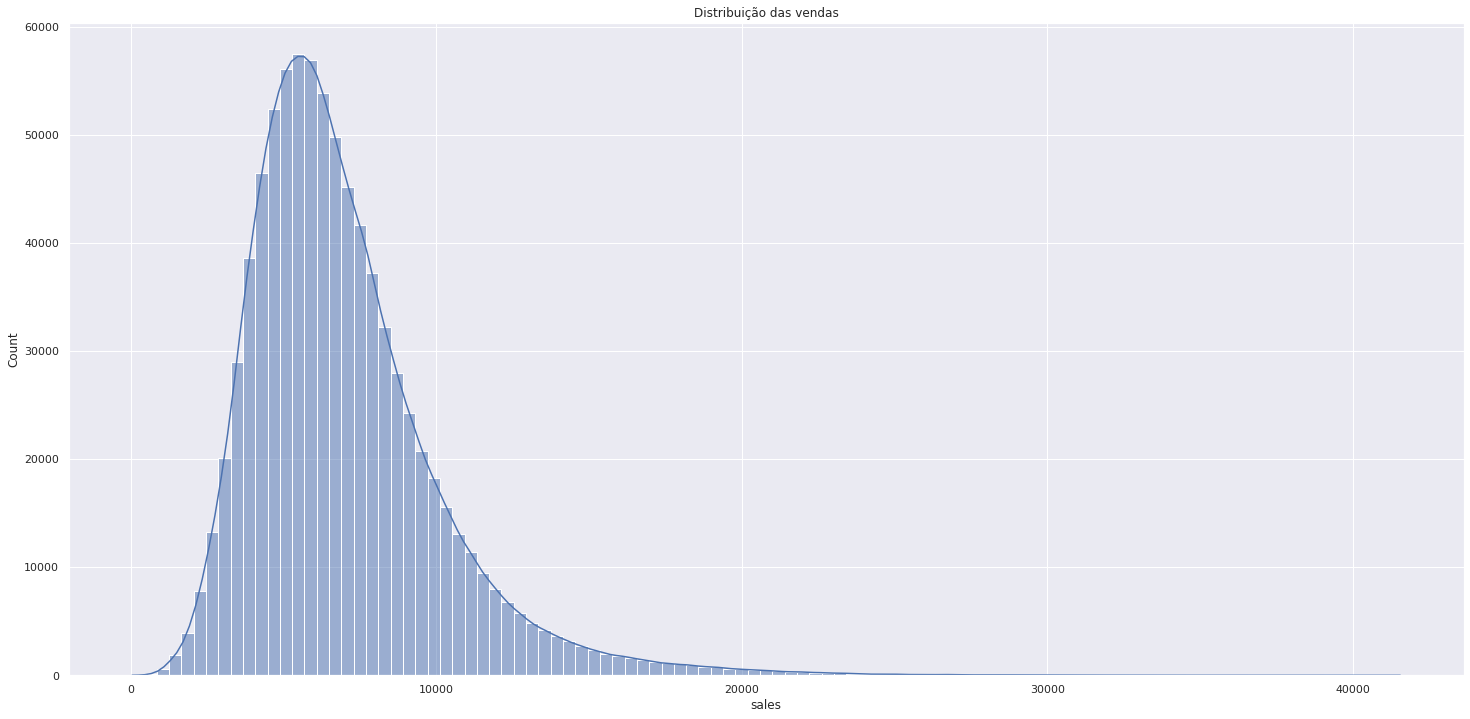

In [ ]:
#@title Histograma: Sales
sns.histplot(df4.sales, kde=True, bins= int((df4.sales.max()-df4.sales.min())/400))
plt.title('Distribuição das vendas');

#### 4.1.2 Estatística Descritiva

###### 4.1.2.1 Atributos Numéricos:

In [ ]:
#Central Tendency - mean, median

#Variáveis numéricas:
ct_mean = pd.DataFrame(num_attributes.apply(np.mean)).T #.T = transposto
ct_median = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersão - std,min,max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenando
m = pd.concat([d2,d3,d4,ct_mean,ct_median,d1,d5,d6]).T.reset_index()
           

In [ ]:
m.columns = ['Variável','min','max','Amplitude','média','mediana','Desvio Padrão','Assimetria','Curtose']

m 

,Variável,min,max,Amplitude,média,mediana,Desvio Padrão,Assimetria,Curtose
0,store,1.0,1115.0,1114.0,558.421374,558.0,321.730671,0.000426,-1.198836
1,day_of_week,1.0,7.0,6.0,3.520350,3.0,1.723711,0.019310,-1.259347
2,sales,46.0,41551.0,41505.0,6955.959134,6369.0,3103.813677,1.594929,4.854027
3,promo,0.0,1.0,1.0,0.446356,0.0,0.497114,0.215824,-1.953425
4,school_holiday,0.0,1.0,1.0,0.193578,0.0,0.395102,1.551109,0.405939
5,competition_distance,20.0,200000.0,199980.0,5961.827515,2330.0,12592.173650,10.134908,145.288658
6,competition_open_since_month,1.0,12.0,11.0,6.787355,7.0,3.309915,-0.048451,-1.231875
7,competition_open_since_year,1900.0,2015.0,115.0,2010.331102,2012.0,5.502625,-7.217323,123.903078
8,promo2,0.0,1.0,1.0,0.498670,0.0,0.499998,0.005320,-1.999976
9,promo2_since_week,1.0,52.0,51.0,23.629083,22.0,14.288306,0.170399,-1.194815


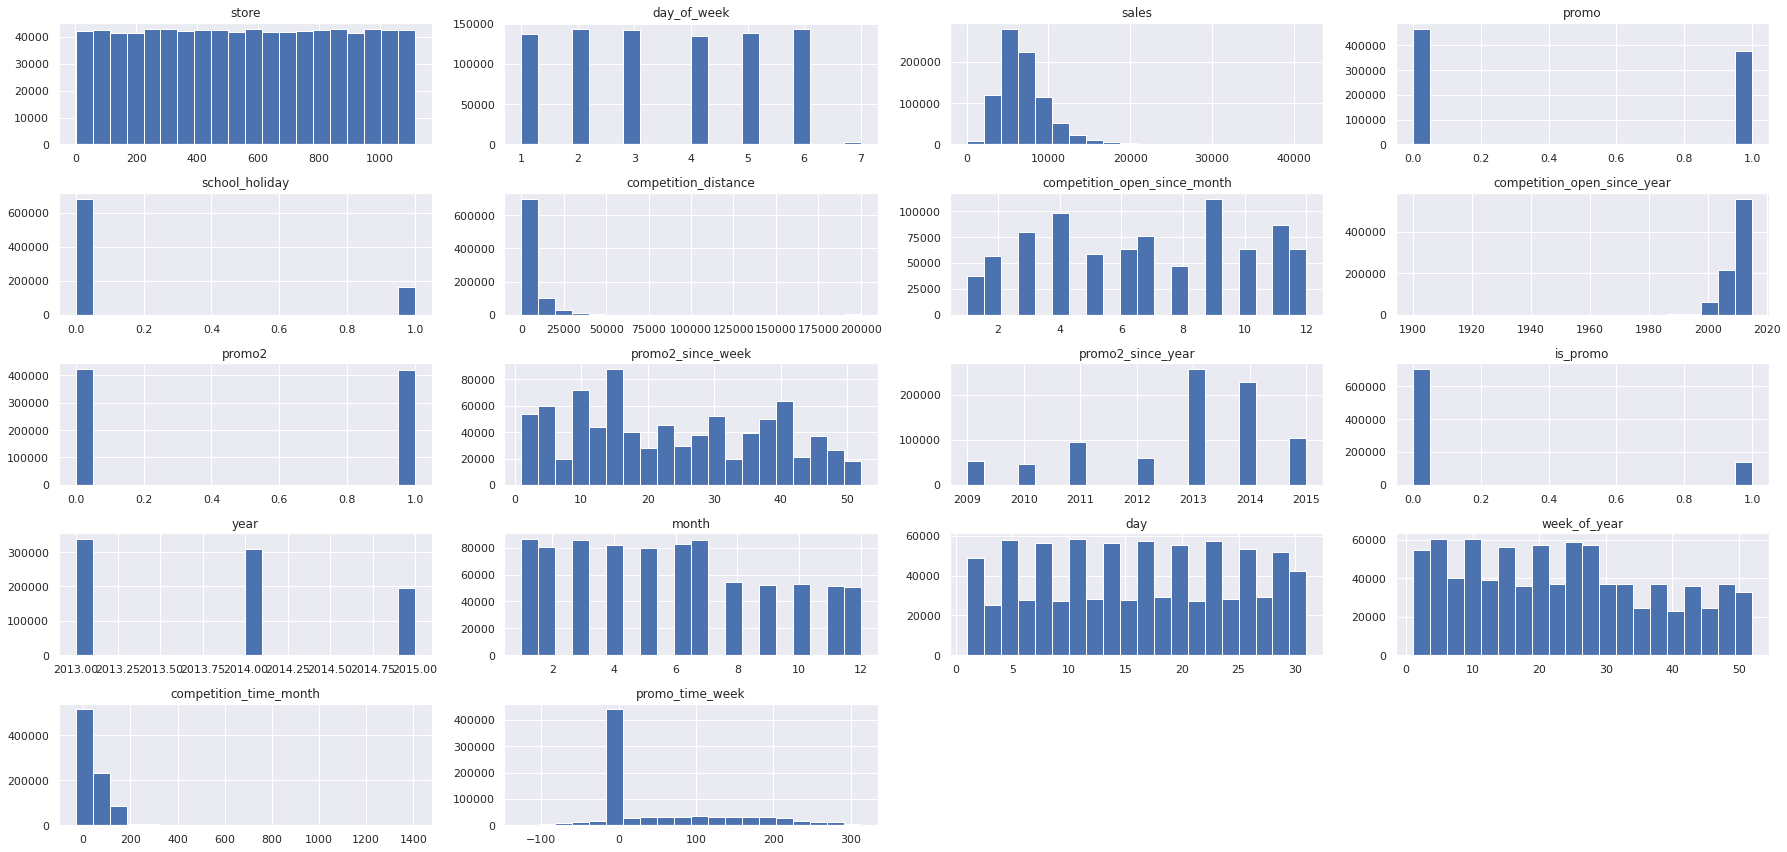

In [ ]:
#@title Distribuição das variáveis numéricas
num_attributes.hist(bins=20);
plt.tight_layout()

###### 4.1.2.2 Atributos Categóricos:

In [ ]:
#Visualizando valores únicos
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
year_week        137
dtype: int64

In [ ]:
df4['store_type'].drop_duplicates();

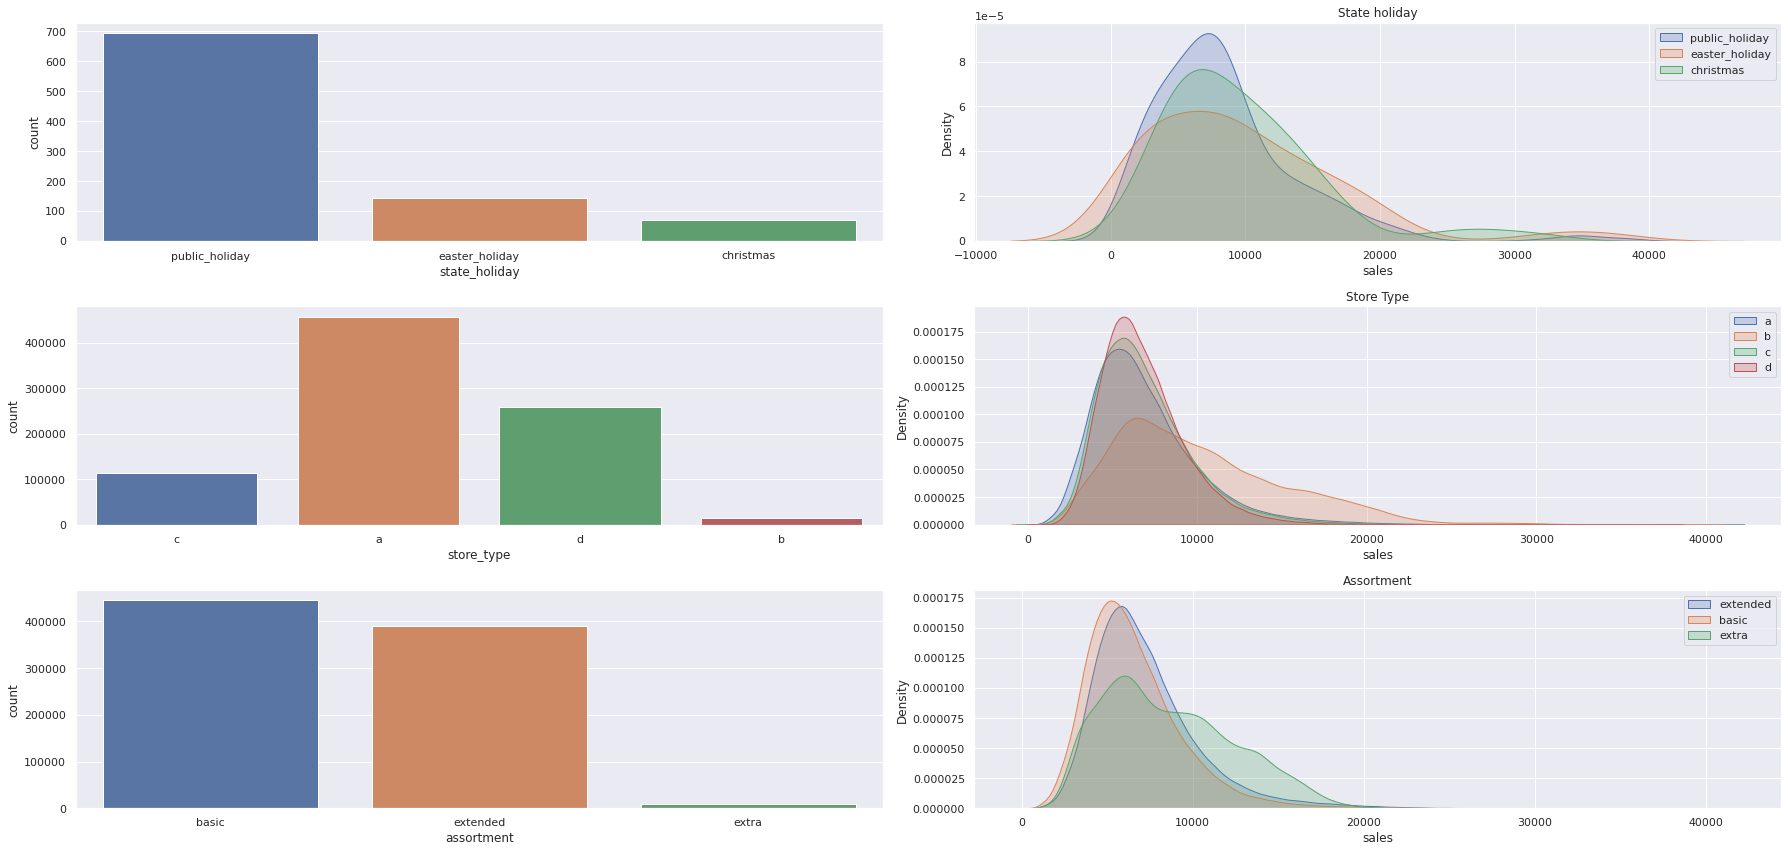

In [ ]:
#@title Distribuição das variáveis categóricas (clique 2x para visualizar o código)

#state_holiday
plt.subplot(3,2,1);
a = df4[df4['state_holiday']!= 'regular_day'];
sns. countplot(x = a['state_holiday']);

plt.subplot(3,2,2);
sns.kdeplot(x = df4[df4['state_holiday']=='public_holiday'][
            'sales'], shade=True );
sns.kdeplot(x = df4[df4['state_holiday']=='easter_holiday'][
            'sales'], shade=True);
sns.kdeplot(x = df4[df4['state_holiday']=='christmas']['sales'], shade=True);
plt.legend( ('public_holiday','easter_holiday','christmas'),
           loc='upper right');
plt.title('State holiday');

#store_type
plt.subplot(3,2,3);
sns.countplot(x = df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(x = df4[df4['store_type']=='a']['sales'],shade=True );
sns.kdeplot(x = df4[df4['store_type']=='b']['sales'], shade=True);
sns.kdeplot(x = df4[df4['store_type']=='c']['sales'], shade=True);
sns.kdeplot(x = df4[df4['store_type']=='d']['sales'], shade=True);
plt.title('Store Type');
plt.legend( ('a','b','c','d'),  loc='upper right');

#assortment
plt.subplot(3,2,5);
sns.countplot(x = df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(x = df4[df4['assortment']=='extended']['sales'],shade=True );
sns.kdeplot(x = df4[df4['assortment']=='basic']['sales'], shade=True);
sns.kdeplot(x = df4[df4['assortment']=='extra']['sales'], shade=True);
plt.title('Assortment');
plt.legend( ('extended','basic','extra'),  loc='upper right');

plt.tight_layout();

## 4.2. Análise Bivariada

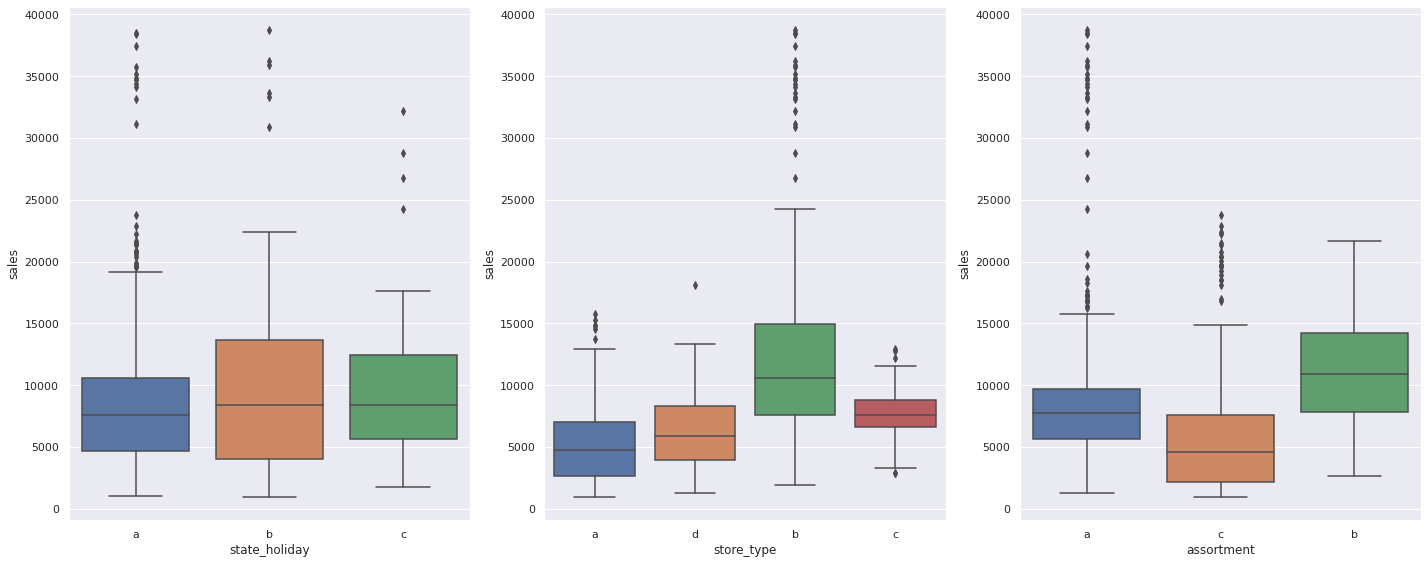

In [ ]:
#@title 4.2.1 Variáveis Categóricas x Vendas
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]
plt.figure(figsize = (20,8))
plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data=aux1)
plt.tight_layout()

### 4.2.2 Validação de Hipóteses

#### H1. Lojas com maior sortimento deveriam vender mais.



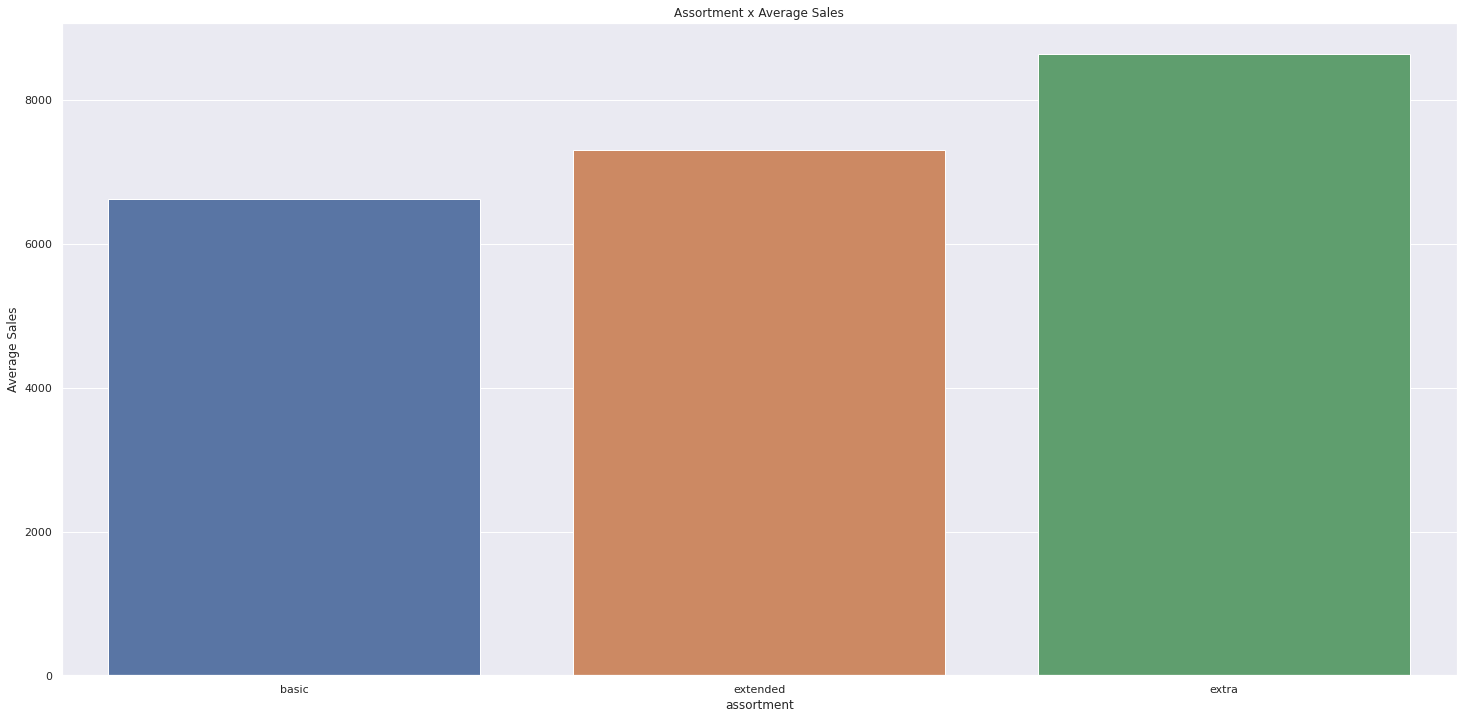

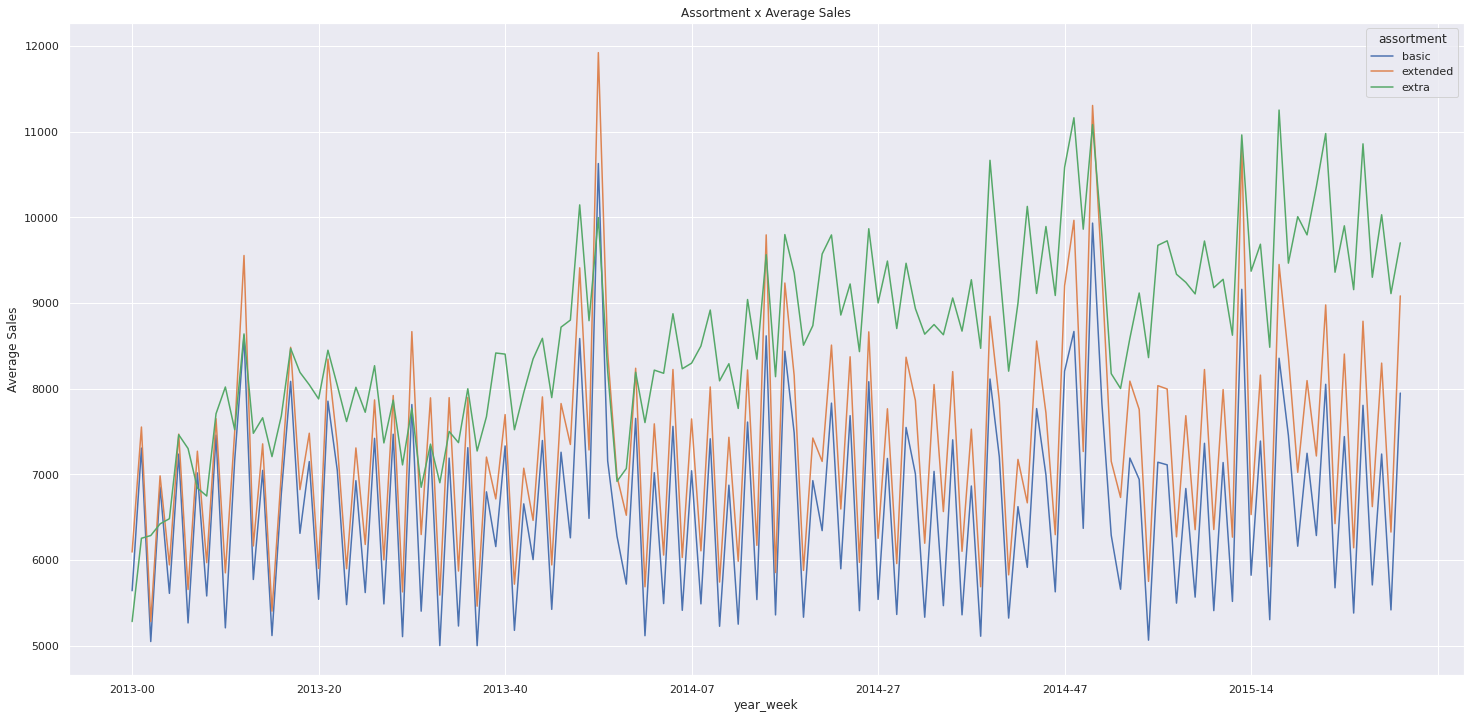

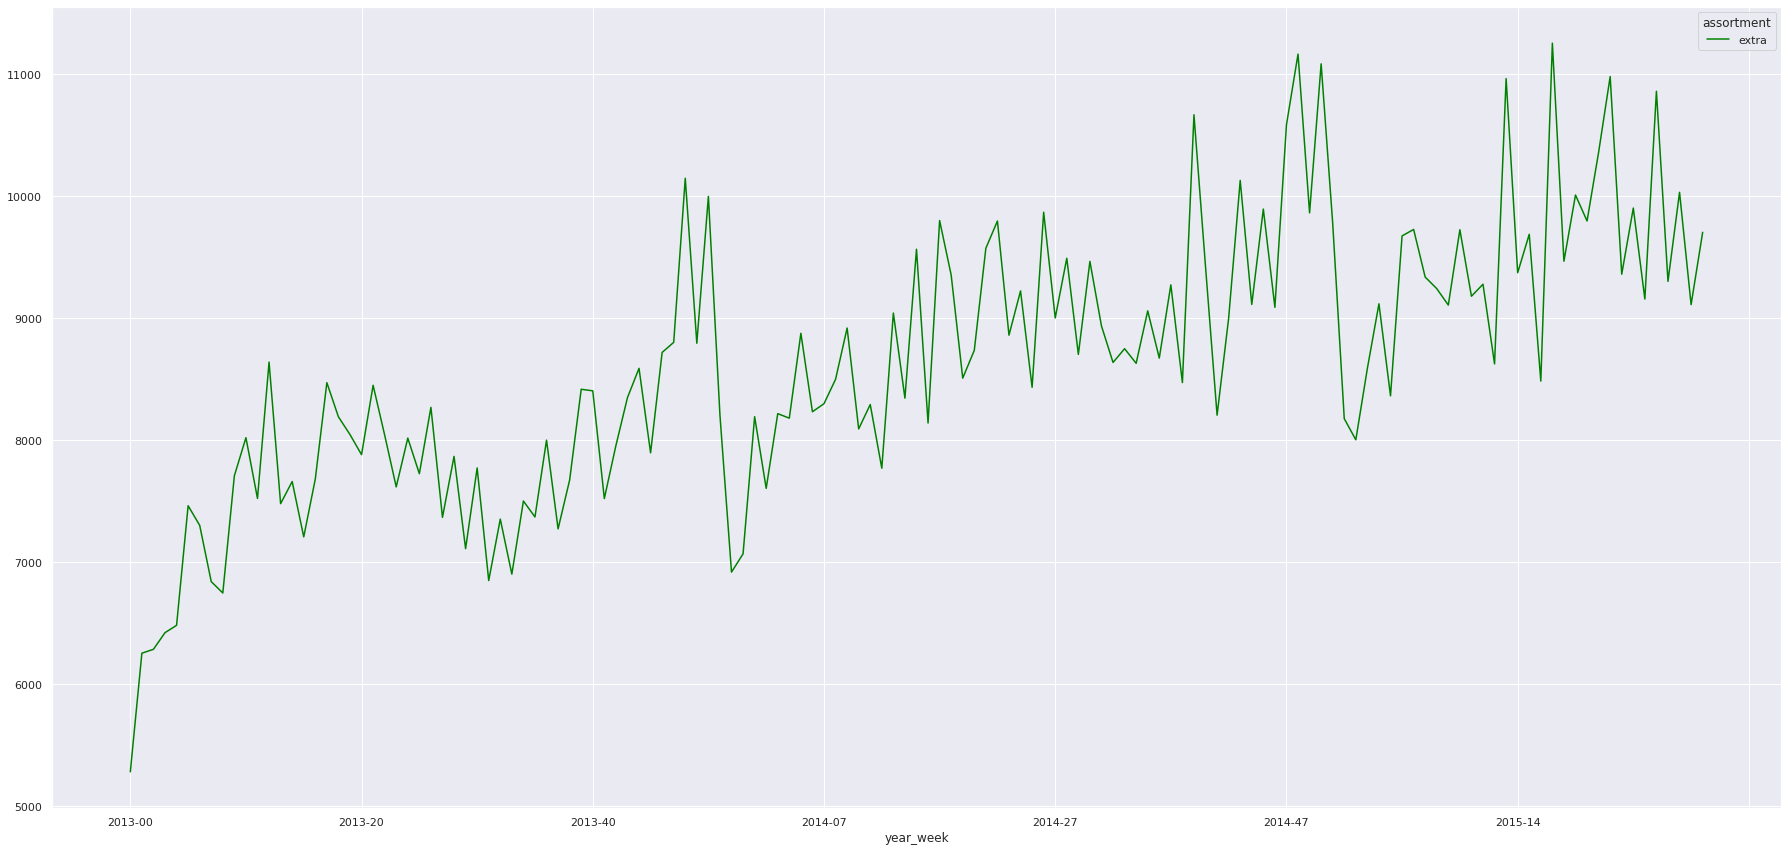

In [ ]:
#@title **Verdadeiro.** Na média, as lojas com mais sortimento (extra) vendem mais.
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment',y='sales', data=aux1);
plt.ylabel("Average Sales")
plt.title("Assortment x Average Sales")

aux2 = df4[['year_week','assortment', 'sales']].groupby(
        ['year_week','assortment']).mean().reset_index()
        
aux2.pivot(index='year_week', columns='assortment',values='sales').plot()      
plt.ylabel("Average Sales")
plt.title("Assortment x Average Sales")

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment',
           values='sales').plot(color = 'green')      

plt.tight_layout()

#### H2. Lojas com competidores mais próximos deveriam vender menos.

Text(0.5, 1.0, 'Competition distance x Average Sales')

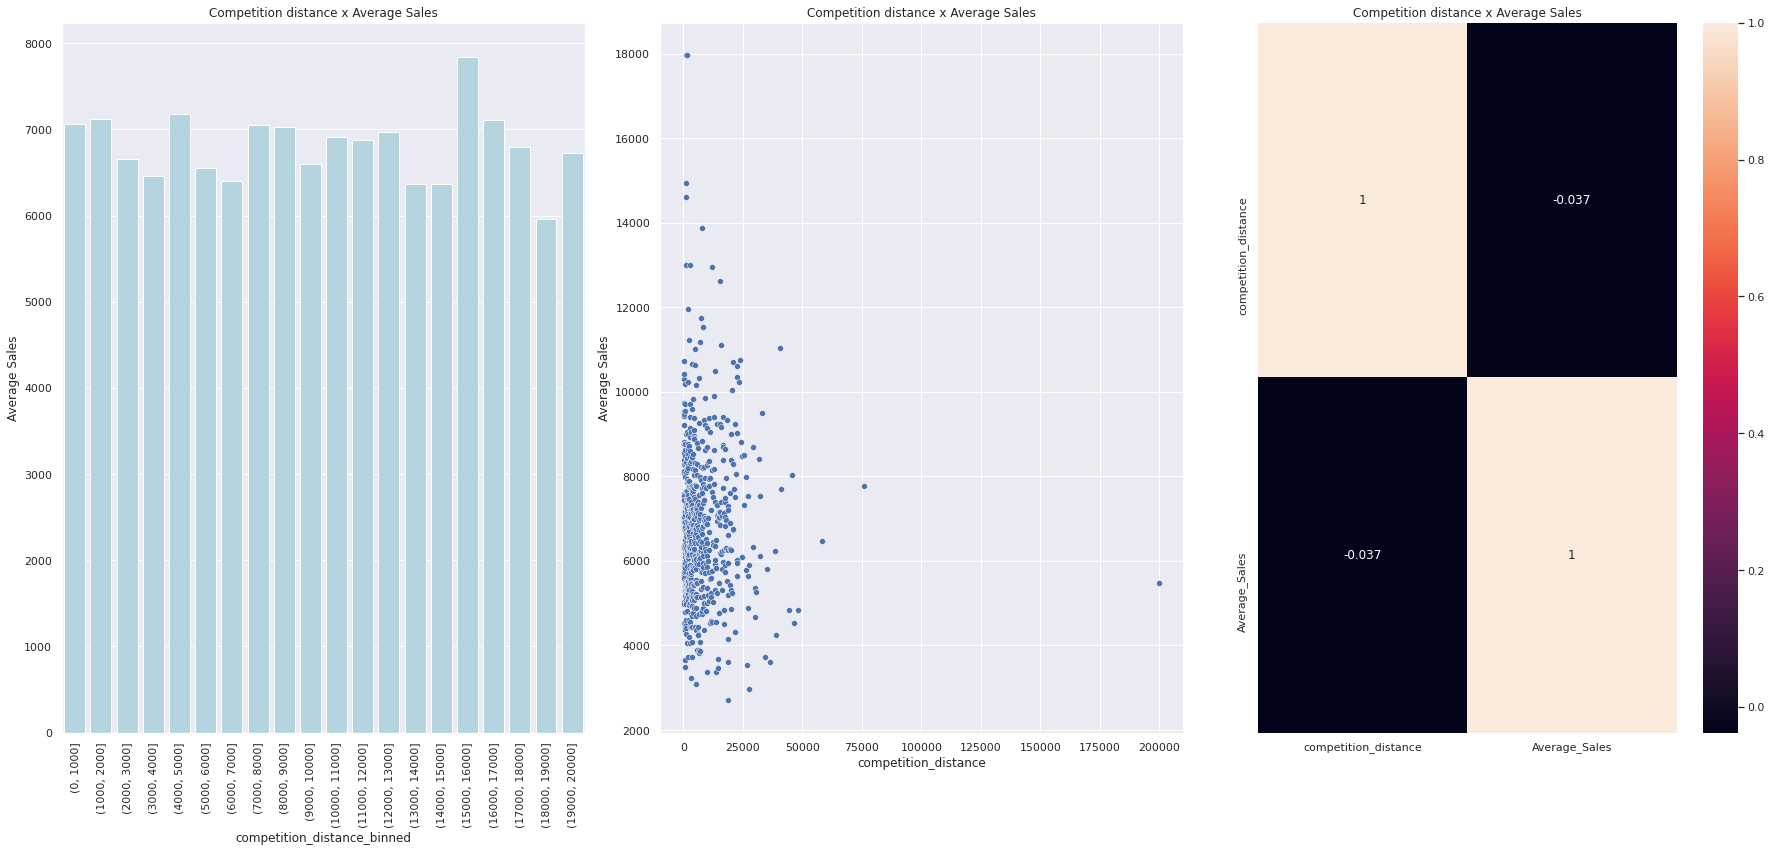

In [ ]:
#@title Falsa! Não aparenta haver correlação entre a média de vendas e a distância dos competidores.

aux1 = df4[['competition_distance', 'sales']].groupby(
          'competition_distance',).mean().reset_index()

bins = list(range(0,21000,1000))
aux1['competition_distance_binned'] = pd.cut(
      aux1['competition_distance'], bins=bins) 

aux2 =  aux1[['competition_distance_binned', 'sales']].groupby(
        'competition_distance_binned',).mean().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'competition_distance_binned', y='sales',data = aux2,
            color='lightblue') 
plt.xticks(rotation=90)
plt.title("Competition distance x Average Sales")
plt.ylabel("Average Sales")


plt.subplot(1,3,2)
sns.scatterplot(x = 'competition_distance', y='sales', data = aux1 )
plt.title("Competition distance x Average Sales")
plt.ylabel("Average Sales")

#medindo a correlação
plt.subplot(1,3,3)
aux1.rename({'sales': 'Average_Sales'}, axis=1, inplace=True)

sns.heatmap(aux1.corr(method='pearson'),annot=True)
plt.tight_layout()
plt.title("Competition distance x Average Sales")

#### H3. Lojas com competidores a mais tempo deveriam vender mais.

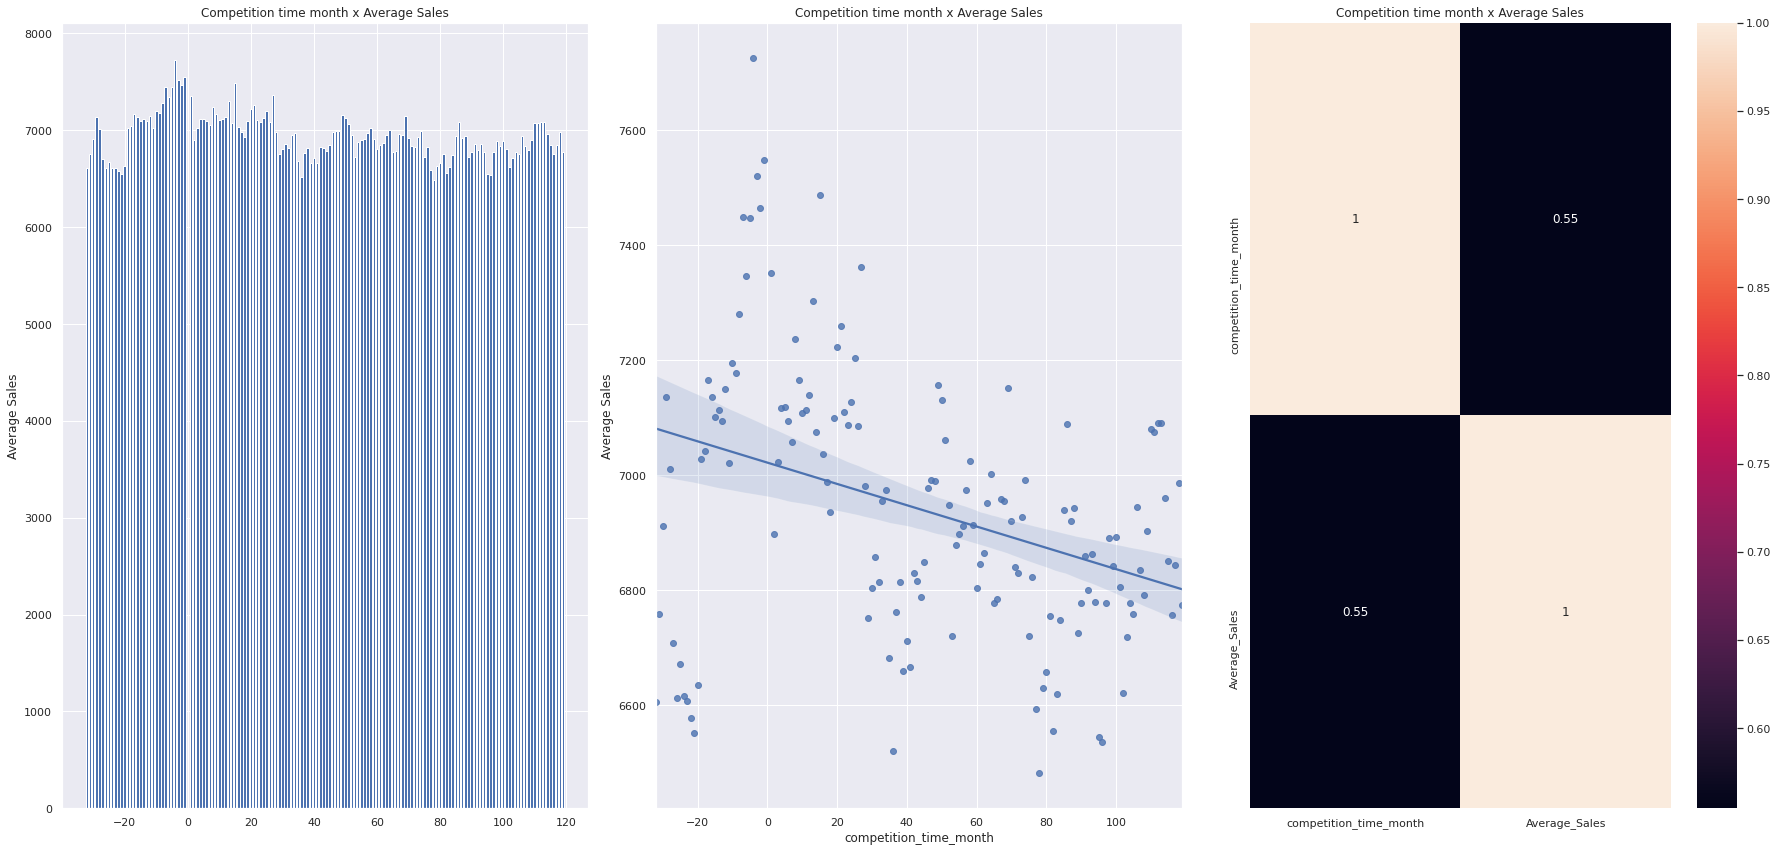

In [ ]:
#@title **Falso.** Lojas com competidores a mais tempo tendem a vender, em média, menos.
aux1 = df4[['competition_time_month', 'sales']].groupby(
          'competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] <120) & (
       aux1['competition_time_month'] !=0 )]

plt.subplot(1,3,1)
#sns.barplot();
plt.bar(x= 'competition_time_month',height='sales',data = aux2)


plt.title("Competition time month x Average Sales")
plt.ylabel("Average Sales")

plt.subplot(1,3,2)
sns.regplot(x= 'competition_time_month',y='sales',data = aux2);
plt.title("Competition time month x Average Sales")
plt.ylabel("Average Sales")

plt.subplot(1,3,3)
aux1.rename({'sales': 'Average_Sales'}, axis=1, inplace=True)
sns.heatmap(aux1.corr(method='pearson'),annot=True)
plt.title("Competition time month x Average Sales")

plt.tight_layout()

#### H4. Lojas com promoções ativas por mais tempo nos produtos deveriam vender mais.

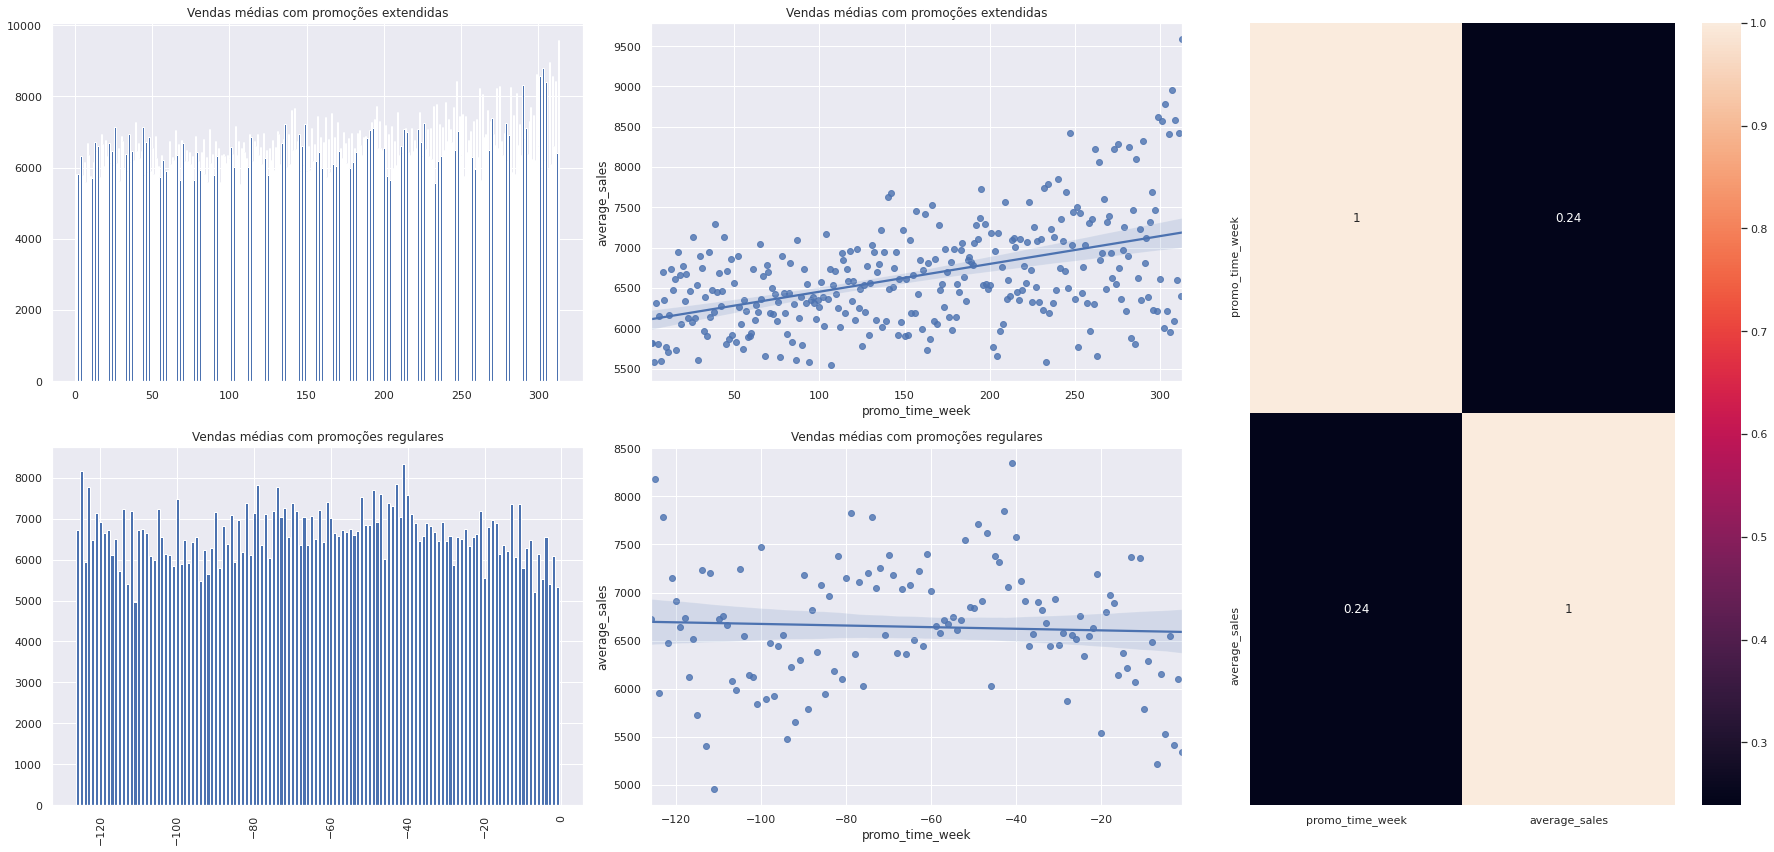

In [ ]:
#@title **Verdadeiro.** Quanto mais tempo uma loja fica com promoções extendidas, maior tende a ser a média de vendas. Entretanto, o mesmo não ocorre para as promoções regulares, que não aparentam influenciar nas vendas médias.

aux1=df4[['promo_time_week', 'sales']].groupby(
         'promo_time_week').mean().reset_index()
aux1.rename({'sales': 'average_sales'}, axis=1, inplace=True)

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] #promoção extendida

plt.bar(x='promo_time_week', height='average_sales',data=aux2);
plt.title("Vendas médias com promoções extendidas")

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='average_sales',data=aux2);
plt.title("Vendas médias com promoções extendidas")

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] #promoção regular
plt.bar(x='promo_time_week', height='average_sales',data=aux3);
plt.xticks(rotation=90)
plt.title("Vendas médias com promoções regulares")

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y= 'average_sales', data=aux3);
plt.title("Vendas médias com promoções regulares")

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

plt.tight_layout()


#### H5. Lojas com mais promoções consecutivas deveriam vender mais.

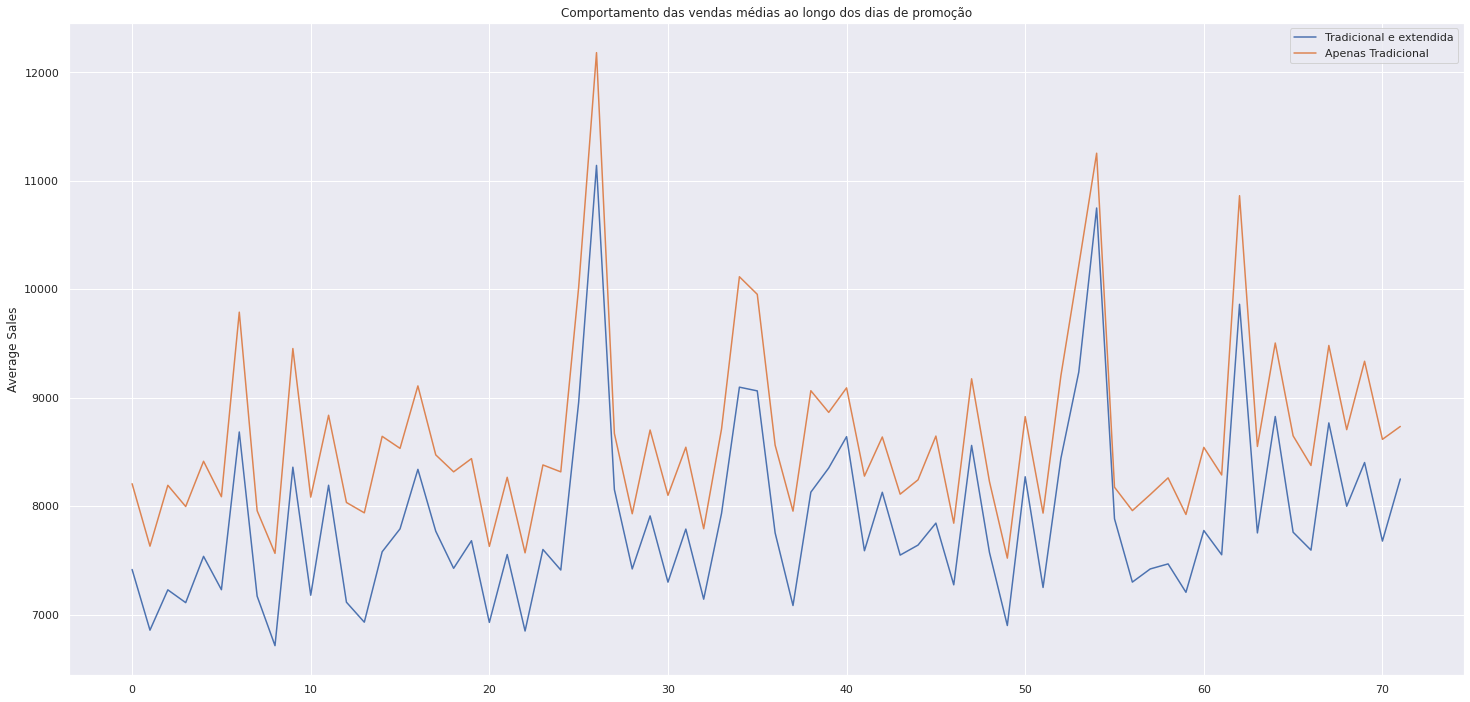

In [ ]:
#@title **Falso.** Lojas que realizam apenas uma promoção vendem, em média, mais.
df4[['promo','promo2','sales']].groupby(['promo','promo2']
            ).mean().reset_index().sort_values(by='sales')

#Vendo o comportamento ao longo do tempo
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][[
      'year_week','sales']].groupby('year_week').mean().reset_index()

ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][[
      'year_week','sales']].groupby('year_week').mean().reset_index()
      
aux2.plot(ax=ax)
ax.legend(labels = ['Tradicional e extendida', 'Apenas Tradicional'])
plt.ylabel("Average Sales")
plt.title("Comportamento das vendas médias ao longo dos dias de promoção");

#### H6. Lojas abertas durante o Natal deveriam vender mais.


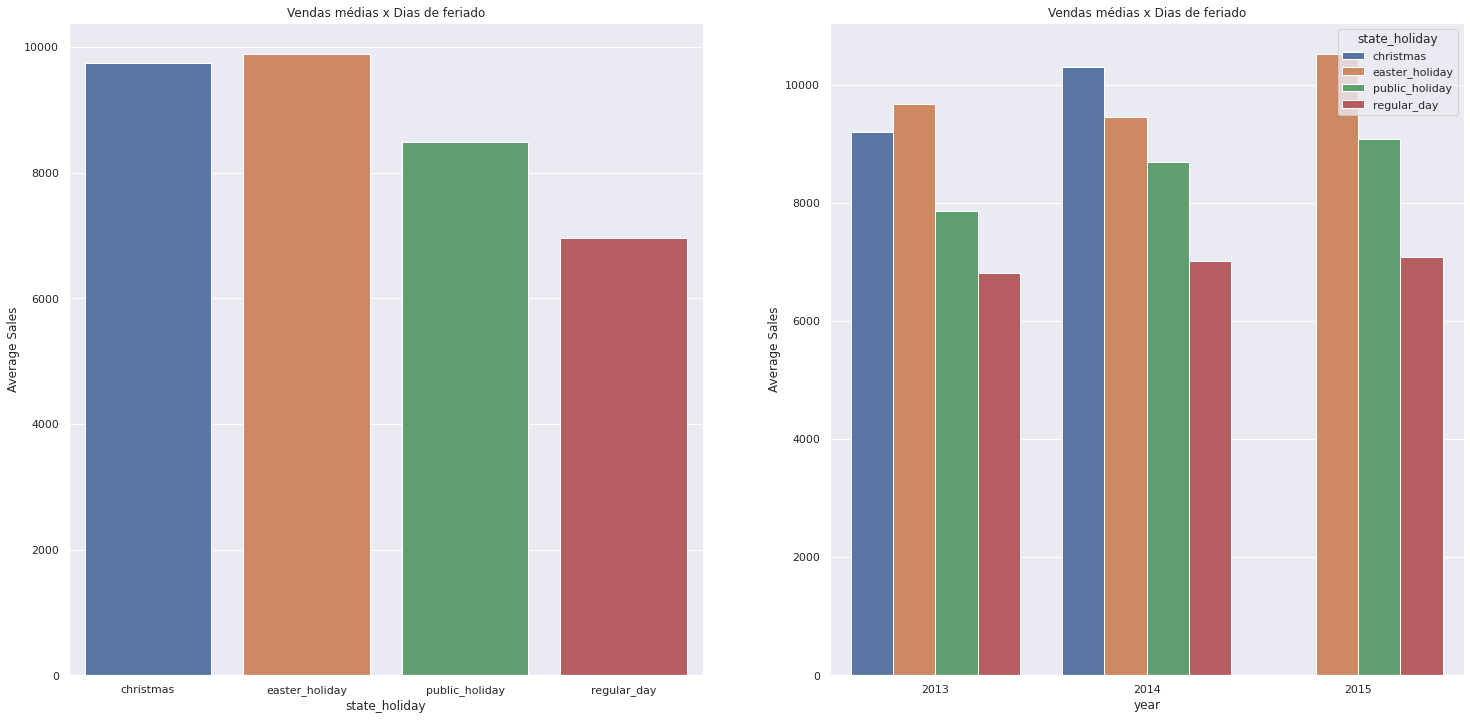

In [ ]:
#@title **Verdadeiro.** As vendas médias no natal são maiores do que nos dias regulares. Em 2013 as vendas na páscoa foram as maiores, mas em 2014 o natal a ultrapassou.
aux = df4
aux1 = aux[['state_holiday','sales']].groupby('state_holiday'
                                    ).mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales',data=aux1);
plt.ylabel("Average Sales")
plt.title("Vendas médias x Dias de feriado")

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(
       ['year','state_holiday']).mean().reset_index()

sns.barplot(x='year',y='sales',data=aux2, hue='state_holiday' );

plt.ylabel("Average Sales")
plt.title("Vendas médias x Dias de feriado");

#### H7. Lojas deveriam vender mais ao longo dos anos.

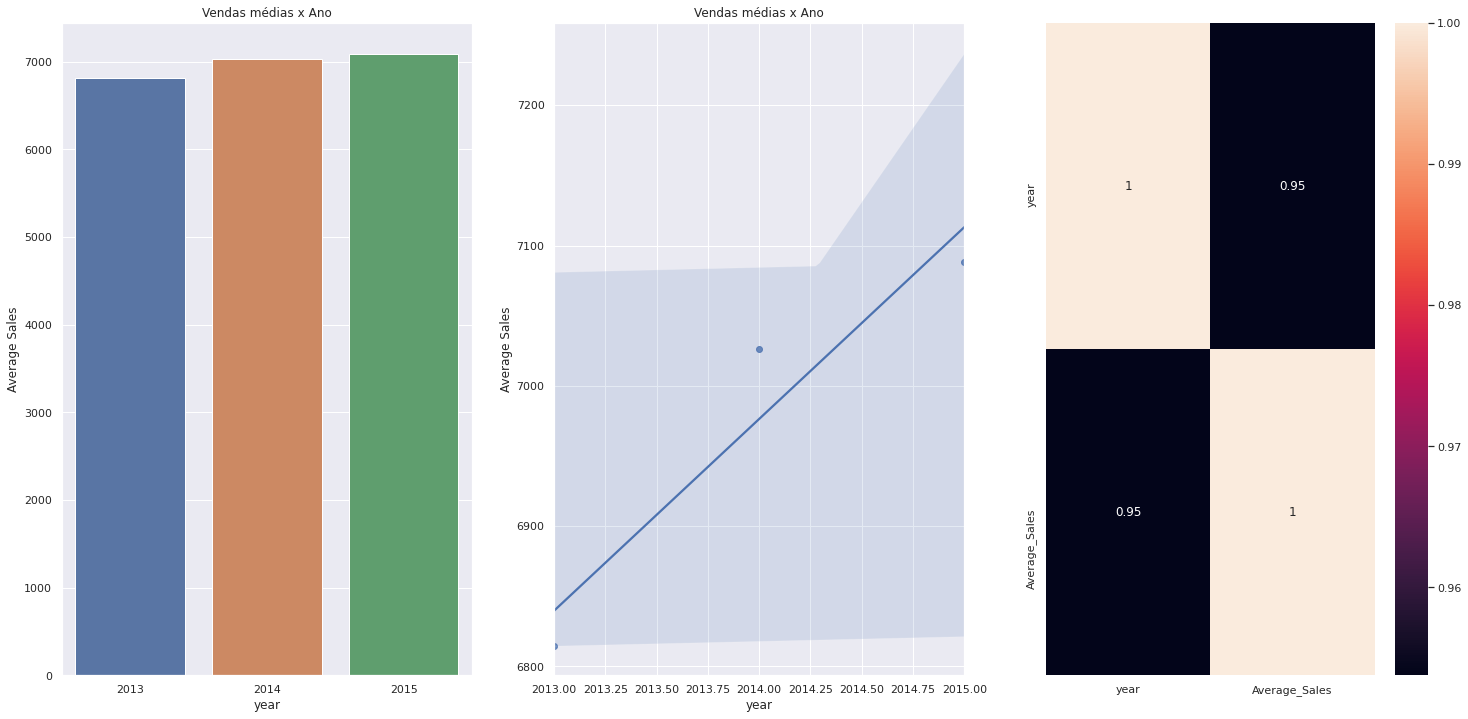

In [ ]:
#@title **Verdadeiro.** A média de vendas vêm aumentando ao longo dos anos.
#obs: 2015 não está completo!
aux1 = df4[['year','sales']].groupby('year').mean().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1);
plt.ylabel("Average Sales")
plt.title("Vendas médias x Ano")
plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);
plt.ylabel("Average Sales")
plt.title("Vendas médias x Ano")
aux1.rename({'sales': 'Average_Sales'}, axis=1, inplace=True)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H8. Lojas deveriam vender mais no segundo semestre do ano.

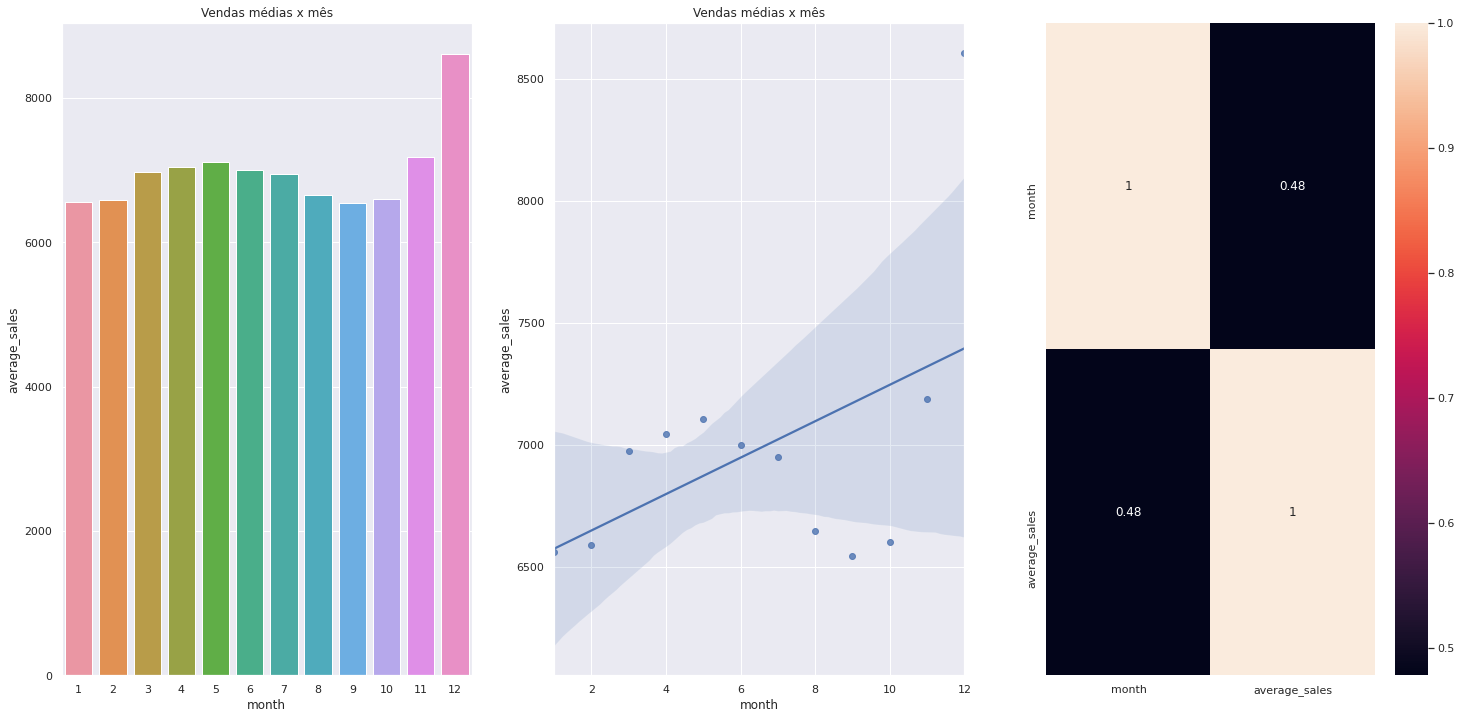

In [ ]:
#@title **Verdadeiro.** As vendas aumentam no final do ano.
aux1 = df4[['month','sales']].groupby('month').mean().reset_index()
aux1.rename({'sales': 'average_sales'},axis=1, inplace=True)
plt.subplot(1,3,1)
sns.barplot(x='month', y='average_sales',data=aux1);
plt.title("Vendas médias x mês")

plt.subplot(1,3,2)
sns.regplot(x='month',y='average_sales',data=aux1);
plt.title("Vendas médias x mês")

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H9. Lojas deveriam vender mais depois do dia 10 de cada mês.

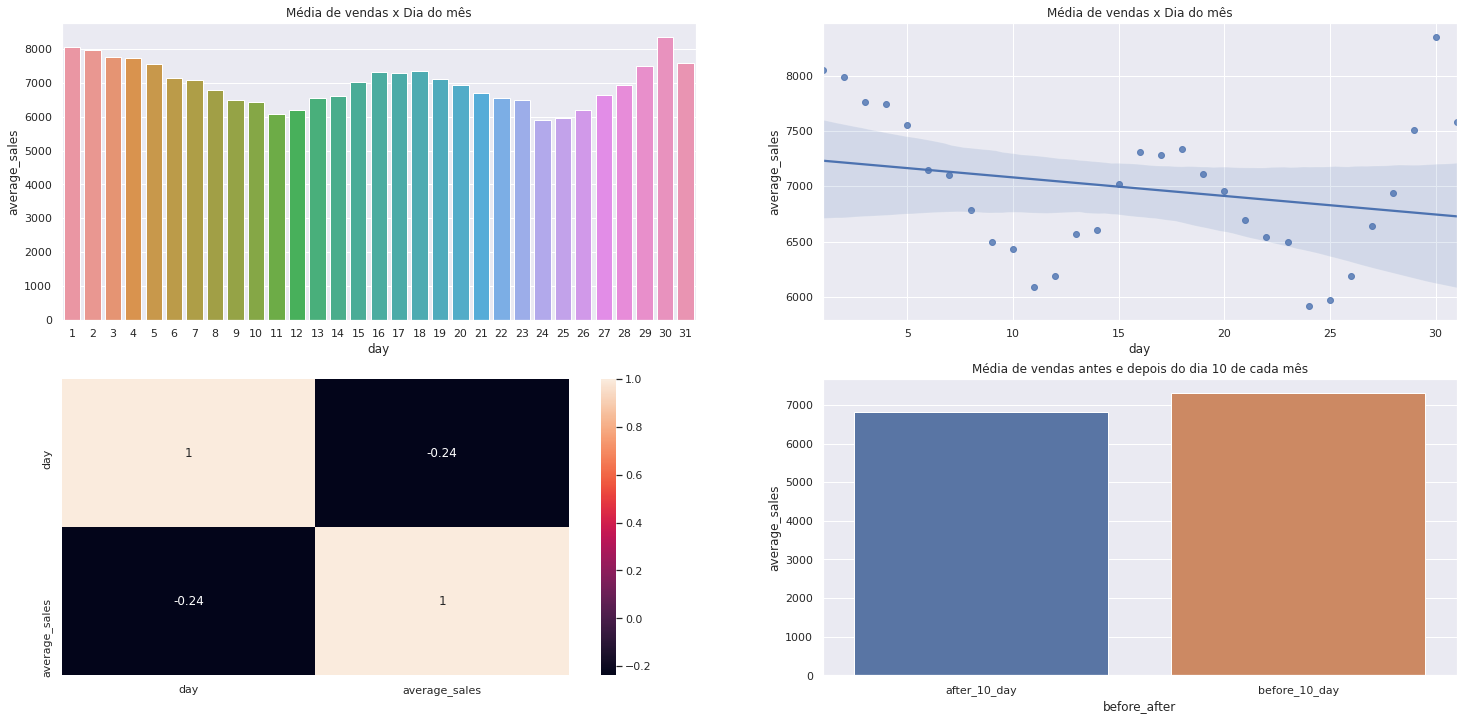

In [ ]:
#@title **Falso.** As vendas médias são levemente maiores antes do dia 10. Há uma leve tendência de queda nas vendas médias ao longo do mês.
aux1 = df4[['day','sales']].groupby('day').mean().reset_index()
aux1.rename({'sales': 'average_sales'},axis=1, inplace=True)

plt.subplot(2,2,1)
sns.barplot(x='day',y='average_sales',data=aux1);
plt.title("Média de vendas x Dia do mês")

plt.subplot(2,2,2)
sns.regplot(x='day',y='average_sales',data=aux1);
plt.title("Média de vendas x Dia do mês")

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after']=aux1['day'].apply(lambda x:
                    'before_10_day' if x<=10 else 'after_10_day')


aux2 = aux1[['before_after','average_sales']].groupby('before_after'
                                            ).mean().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='average_sales',data=aux2);
plt.title("Média de vendas antes e depois do dia 10 de cada mês");

#### H10. Lojas deveriam vender menos aos finais de semana.

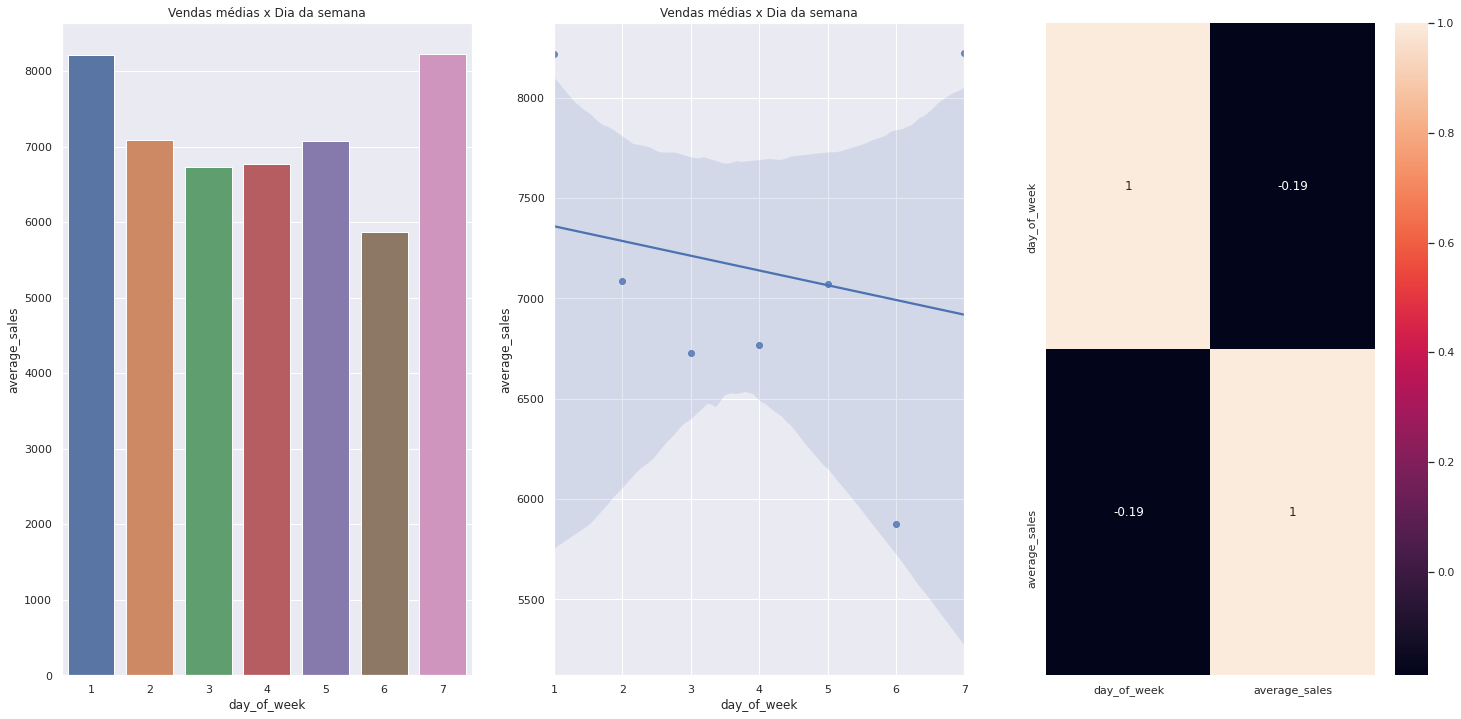

In [ ]:
#@title  **Parcialmente verdadeiro.** As vendas médias são menores nos sábados, mas maiores nos domingos.  
aux1 = df4[['day_of_week','sales']].groupby('day_of_week'
                                  ).mean().reset_index()

aux1.rename({'sales': 'average_sales'}, axis=1, inplace=True)
plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='average_sales',data=aux1);
plt.title("Vendas médias x Dia da semana")

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='average_sales',data=aux1);
plt.title("Vendas médias x Dia da semana")

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H11. Lojas deveriam vender menos durante os feriados escolares.

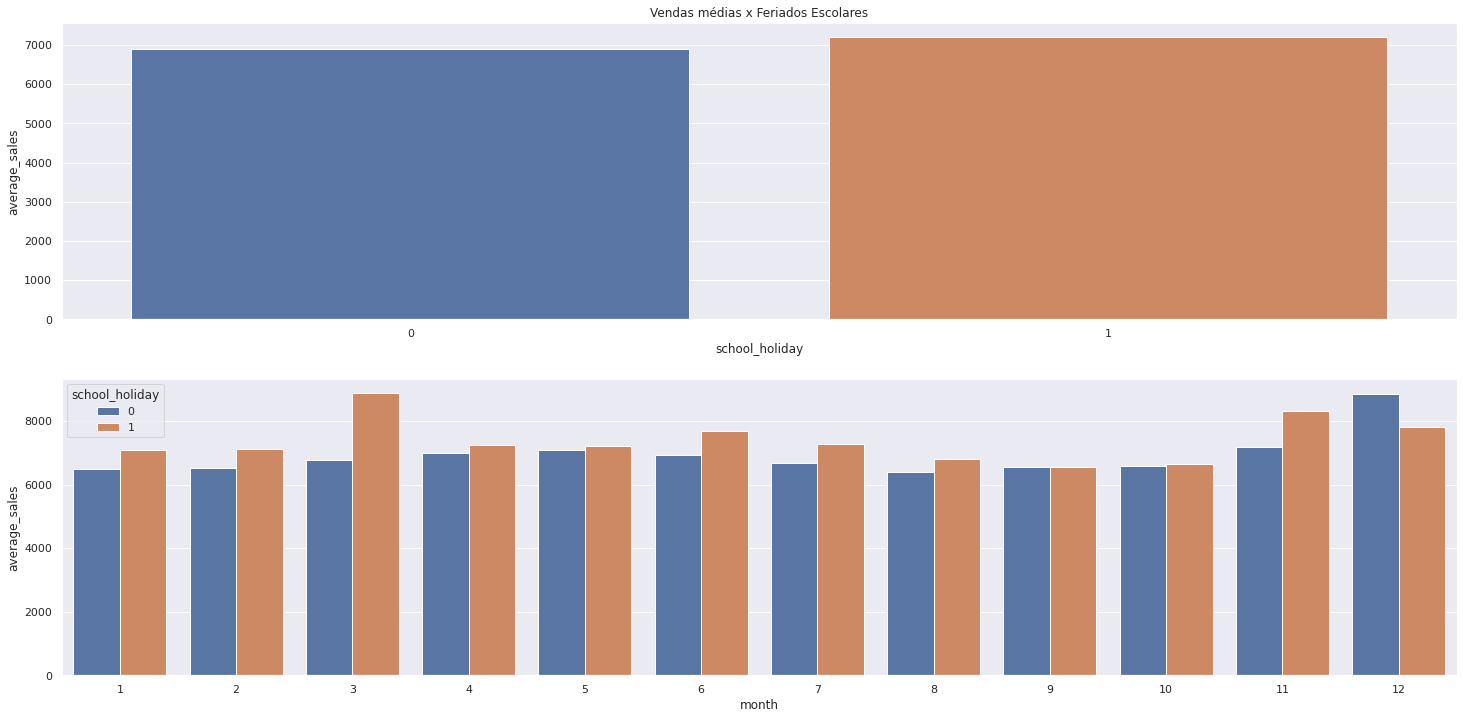

In [ ]:
#@title **Falso.** Em média, as lojas vendem um pouco mais durante os feriados escolares.
aux = df4[['school_holiday','sales']].groupby('school_holiday'
                                    ).mean().reset_index()

aux.rename({'sales': 'average_sales'}, axis=1, inplace=True)

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='average_sales',data=aux);
plt.title("Vendas médias x Feriados Escolares")

aux1 = df4[['month','school_holiday','sales']].groupby(
           ['month','school_holiday']).mean().reset_index()
           
aux1.rename({'sales': 'average_sales'}, axis=1, inplace=True)
plt.subplot(2,1,2)
sns.barplot(x='month', y='average_sales',hue ='school_holiday',data=aux1);

#### 4.2.4.1 Resumo das Hipóteses

In [ ]:
#@title Tabela resumo
tab = [['Hipóteses','Conclusão','Relevância'],
       ['H1','Verdadeira','Alta'],
       ['H2','Falsa','Baixa'],
       ['H3','Falsa','Média'],
       ['H4','Verdadeira','Média'],
       ['H5','Falsa','Baixa'],
       ['H6','Verdadeira','Alta'],
       ['H7','Verdadeira','Média'],
       ['H8','Verdadeira','Alta'],
       ['H9','Falsa','Alta'],
       ['H10','Parc. Verdadeira','Alta'],
       ['H11','Falsa','Alta'],
       ]
print(tabulate(tab,headers='firstrow'))

Hipóteses    Conclusão         Relevância
-----------  ----------------  ------------
H1           Verdadeira        Alta
H2           Falsa             Baixa
H3           Falsa             Média
H4           Verdadeira        Média
H5           Falsa             Baixa
H6           Verdadeira        Alta
H7           Verdadeira        Média
H8           Verdadeira        Alta
H9           Falsa             Alta
H10          Parc. Verdadeira  Alta
H11          Falsa             Alta


## 4.3. Análise Multivariada

#### 4.3.1 Atributos Numéricos

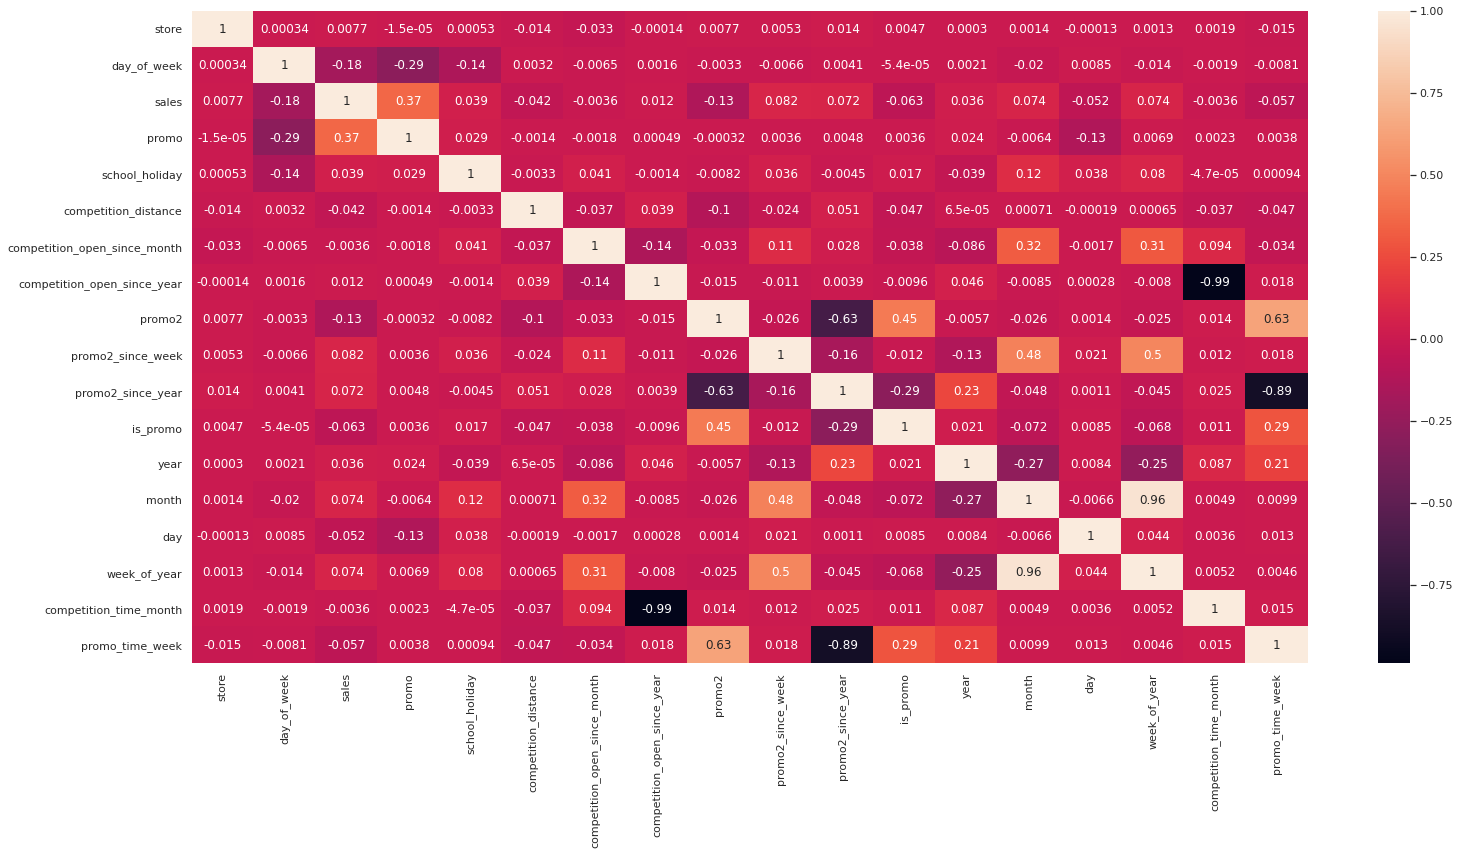

In [ ]:
correlation = num_attributes.corr(method ='pearson')
sns.heatmap(correlation,annot=True);

#### 4.3.2 Atributos Categóricos

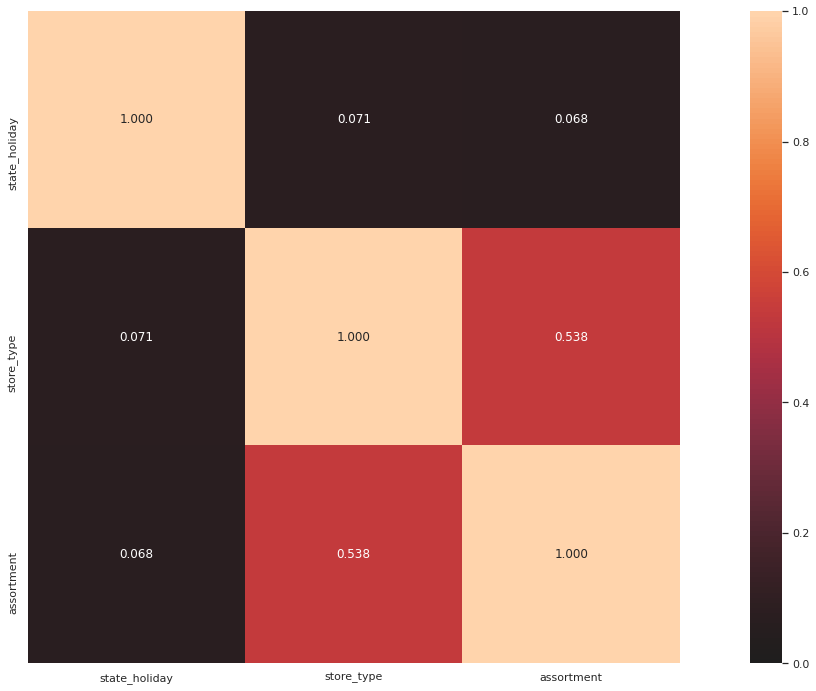

In [ ]:
aux = cat_attributes.drop(columns = 'year_week')
associations(aux,fmt='.3f');

---
# 5.0 PREPARAÇÃO DOS DADOS

In [25]:
df5 = df4.copy()

### 5.1 Split entre treino e teste 

In [26]:
#Qual a data em que inicia as 6 semanas finais?
df5[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)
# Resposta: 2015-06-19 

Timestamp('2015-06-19 00:00:00')

In [27]:
#dataset de treino
df_treino = df5[df5['date']< '2015-06-19']

#dateset de test
df_teste = df5[df5['date'] >= '2015-06-19']

print('Data mínima de treino: {}'.format(df_treino['date'].min()))
print('Data Máxima de treino: {}'.format(df_treino['date'].max()))

print('Data mínima de teste: {}'.format(df_teste['date'].min()))
print('Data máxima de teste: {}'.format(df_teste['date'].max()))

Data mínima de treino: 2013-01-01 00:00:00
Data Máxima de treino: 2015-06-18 00:00:00
Data mínima de teste: 2015-06-19 00:00:00
Data máxima de teste: 2015-07-31 00:00:00


### 5.2 Normalização

In [28]:
#Nenhuma coluna tem distribuição semelhante à normal

### 5.3 Rescaling

In [29]:
# - MinMax scaler para distribuições sem muitos outliers
# - Robust scaler para distribuições com muitos outliers
num = df_treino.select_dtypes(include=['int64','float64','int32','float32'])

Text(0.5, 1.0, 'Year')

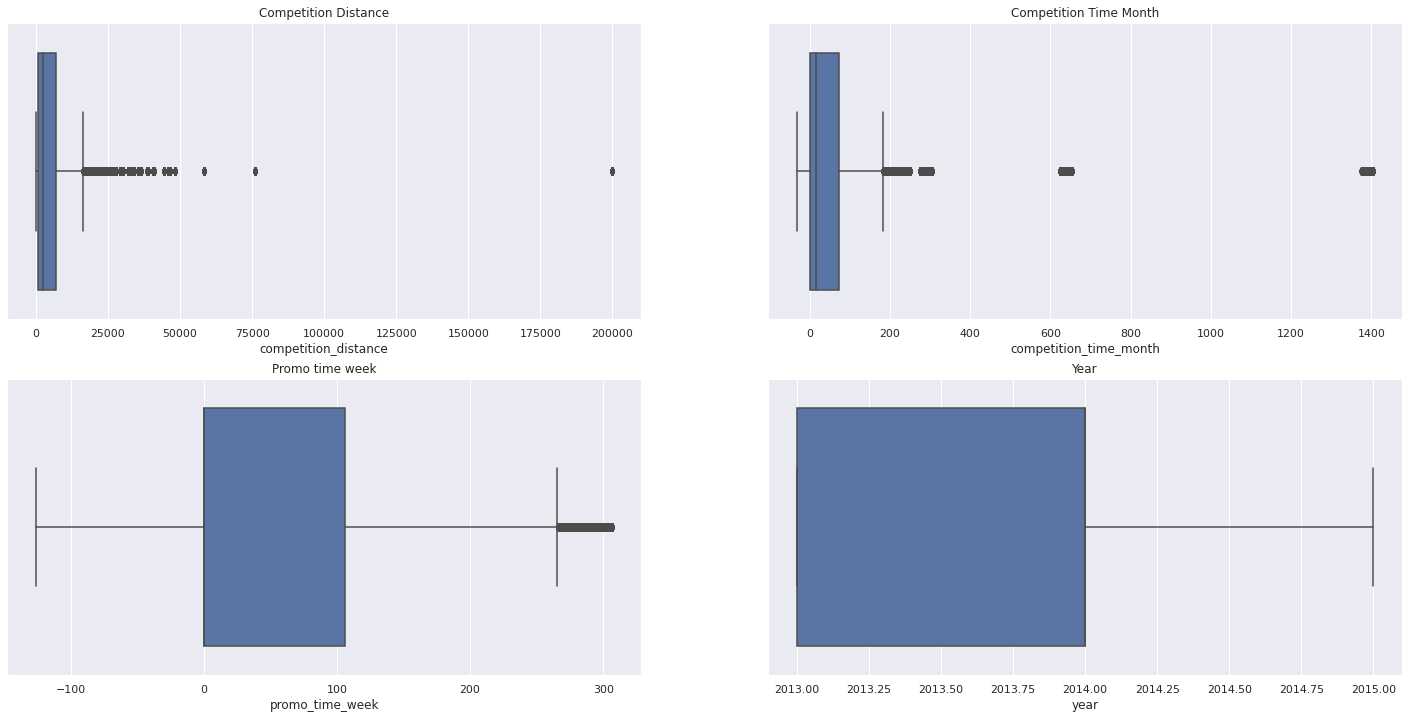

In [30]:
plt.subplot(2,2,1)
sns.boxplot(x = df_treino['competition_distance']); #muitos outliers, usar RobustScaler
plt.title("Competition Distance")

plt.subplot(2,2,2)
sns.boxplot(x = df_treino['competition_time_month']); #muitos outliers, usar RobustScaler
plt.title("Competition Time Month")

plt.subplot(2,2,3) 
sns.boxplot(x = df_treino['promo_time_week']); #poucos outliers, usar MinMaxScaler
plt.title("Promo time week")

plt.subplot(2,2,4) 
sns.boxplot(x= df_treino['year']); #poucos outliers, usar MinMaxScaler
plt.title("Year")

In [ ]:
#Fazendo o Rescaling:

rs = RobustScaler()
mm = MinMaxScaler()

#competition distance
df_treino['competition_distance'] = rs.fit_transform(df_treino[['competition_distance']].values);
df_teste['competition_distance'] = rs.transform(df_teste[['competition_distance']].values);

#Fazendo o dump da transformação no pickle (para posteriormente colocar o modelo em produção):
pickle.dump(rs, open('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/Parameter/competition_distance_scaler.pkl', 'wb'))

#competition time month
df_treino['competition_time_month'] = rs.fit_transform(df_treino[['competition_time_month']].values);
df_teste['competition_time_month'] = rs.transform(df_teste[['competition_time_month']].values);

pickle.dump(rs, open('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/Parameter/competition_time_month_scaler.pkl', 'wb'))

#promo time week
df_treino['promo_time_week'] = mm.fit_transform(df_treino[['promo_time_week']].values);
df_teste['promo_time_week'] = mm.transform(df_teste[['promo_time_week']].values);

pickle.dump(mm, open('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/Parameter/promo_time_week_scaler.pkl', 'wb'))

#year
df_treino['year'] = mm.fit_transform(df_treino[['year']].values);
df_teste['year'] = mm.transform(df_teste[['year']].values);

pickle.dump(mm, open('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/Parameter/year_scaler.pkl', 'wb'))

### 5.4 Transformação

#### 5.4.1 Transformação de grandeza da variável de resposta

In [32]:
#Transformação logarítmica
df_treino['sales'] = np.log1p(df_treino['sales'])
df_teste['sales'] = np.log1p(df_teste['sales'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


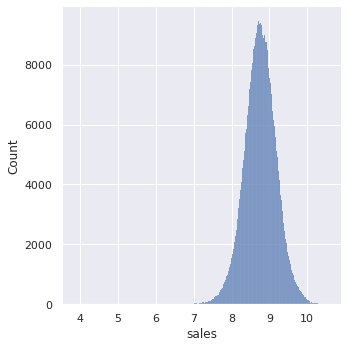

In [33]:
sns.displot(df_treino['sales']);

#### 5.4.2 Transformação de natureza das variáveis temporais

In [34]:
#day of week
df_treino['day_of_week_sin'] = df_treino['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df_treino['day_of_week_cos'] = df_treino['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

df_teste['day_of_week_sin'] = df_teste['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df_teste['day_of_week_cos'] = df_teste['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

#month - transformação cíclica
df_treino['month_sin'] = df_treino['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df_treino['month_cos'] = df_treino['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

df_teste['month_sin'] = df_teste['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df_teste['month_cos'] = df_teste['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

#day
df_treino['day_sin'] = df_treino['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df_treino['day_cos'] = df_treino['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

df_teste['day_sin'] = df_teste['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df_teste['day_cos'] = df_teste['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

#week of year
df_treino['week_of_year_sin'] = df_treino['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df_treino['week_of_year_cos'] = df_treino['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

df_teste['week_of_year_sin'] = df_teste['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df_teste['week_of_year_cos'] = df_teste['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

#### 5.4.3 Encoding

In [35]:
#state_holiday: one-hot encoding
df_treino = pd.get_dummies(df_treino, prefix = ['state_holiday'], columns = ['state_holiday'])
df_teste =  pd.get_dummies(df_teste, prefix = ['state_holiday'], columns = ['state_holiday'])
# Realinhando os datasets:
df_treino, df_teste = df_treino.align(df_teste,join='left',axis=1)

In [36]:
#store_type: label encoding
lb=LabelEncoder()
df_treino['store_type']=lb.fit_transform(df_treino['store_type'])
df_teste['store_type']=lb.transform(df_teste['store_type'])

#Pickle: 
pickle.dump(lb, open('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/Parameter/store_type_scaler.pkl', 'wb'))

In [37]:
#assortment: ordinal encoding
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3
                   }
df_treino['assortment'] = df_treino['assortment'].map(assortment_dict)
df_teste['assortment'] = df_teste['assortment'].map(assortment_dict)

---
# 6.0 SELEÇÃO DE FEATURES

In [38]:
#Dropar variáveis que foram transformadas
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since', 'year_week']
df_treino = df_treino.drop(cols_drop, axis=1)
df_teste = df_teste.drop(cols_drop, axis=1)

### 6.1 Selecionando as melhores Features com o Algoritmo Boruta

In [39]:


# X_train_bor = X_train.drop(columns=['date']).values
# y_train_bor = y_train.values.ravel() #ravel coloca em um vetor

# define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

#define boruta:
# boruta = BorutaPy(rf, n_estimators = 'auto', verbose=2, random_state=1).fit(X_train_bor, y_train_bor)


### 6.2 Obtendo as Melhores Features:

In [40]:

#cols_selected = boruta.support_.tolist()

#best features
#X_train_bf = X_train.drop(columns=['date'])
#cols_selected_boruta = X_train_bf.iloc[:,cols_selected].columns.to_list()

#not selected
#cols_not_selected_boruta = list(np.setdiff1d(X_train_bf.columns, cols_selected_boruta))


### 6.3 Colunas Obtidas

In [41]:
cols_not_selected_boruta= ['is_promo',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'year'] 


In [42]:
cols_selected_boruta = ['assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'competition_time_month',
 'day_sin',
 'day_cos',
 'day_of_week_cos',
 'day_of_week_sin',
 'month_sin',
 'month_cos',
 'promo',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_time_week',
 'store',
 'store_type',
 'week_of_year_sin',
 'week_of_year_cos']

 #colunas para adicionar: 
feat_to_add = ['date', 'sales']

In [43]:
#Features Finais
cols_selected_boruta_full = cols_selected_boruta.copy()

cols_selected_boruta_full.extend(feat_to_add)
cols_selected_boruta_full

['assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'competition_time_month',
 'day_sin',
 'day_cos',
 'day_of_week_cos',
 'day_of_week_sin',
 'month_sin',
 'month_cos',
 'promo',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_time_week',
 'store',
 'store_type',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

---
# 7.0 ELABORAÇÃO DOS MODELOS DE MACHINE LEARNING

In [44]:
#Dataset para o cross validation: 
df_treino_ml = df_treino[cols_selected_boruta_full]
df_teste = df_teste[cols_selected_boruta_full]

In [45]:
y_train = df_treino_ml['sales'] 
X_train = df_treino_ml.drop(columns=['sales','date'])

### 7.1 Modelo de regressão linear: servirá como baseline

In [ ]:
#Model
lr = LinearRegression().fit(X_train,y_train)

#performance
lr_cv = TimeSeries_cross_validation(df_treino_ml, 5, 'Linear Regression', lr )
lr_cv


Kfold_number: 5
MAE = 2646.810011610862
MAPE = 0.31137308327122476
RMSE = 3821.9010057952128

Kfold_number: 4
MAE = 1908.4710905165302
MAPE = 0.32825251975790787
RMSE = 2576.457764050245

Kfold_number: 3
MAE = 1803.9807231985062
MAPE = 0.3040775751546986
RMSE = 2522.9104554950136

Kfold_number: 2
MAE = 2069.335137766159
MAPE = 0.28553250427267596
RMSE = 3001.3342903704197

Kfold_number: 1
MAE = 1980.0391511732432
MAPE = 0.28389281001393885
RMSE = 2840.000319428244


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 7.2 Linear Regression Regularized Model - LASSO

In [ ]:
#Model
lasso = Lasso(alpha = 0.01).fit(X_train,y_train)

#performance - cross validation
lasso_cv = TimeSeries_cross_validation(df_treino_ml, 5, 'Lasso - CV', lasso)
lasso_cv #Um pouco pior que a RL comum, o modelo é complexo.


Kfold_number: 5
MAE = 2751.45772969123
MAPE = 0.31444700745755
RMSE = 3976.1698822309354

Kfold_number: 4
MAE = 1846.85134014721
MAPE = 0.2911393742797097
RMSE = 2630.90187654536

Kfold_number: 3
MAE = 1808.434156395209
MAPE = 0.28909616304965313
RMSE = 2594.857897302576

Kfold_number: 2
MAE = 2160.6463422004686
MAPE = 0.2846318024391607
RMSE = 3168.024644041631

Kfold_number: 1
MAE = 2014.533600312529
MAPE = 0.2807205269505963
RMSE = 2918.81744864363


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso - CV,2116.38 +/- 341.51,0.29 +/- 0.01,3057.75 +/- 504.27


### 7.3 Random Forest Regressor

In [47]:
#Modelo
rf = RandomForestRegressor(n_estimators=100, random_state=1).fit(X_train,y_train)

#Avaliação - Cross-Validation
rf_cv = TimeSeries_cross_validation(df_treino_ml, 5, 'RandomForest - CV', rf)
rf_cv


Kfold_number: 5
MAE = 1192.863605614469
MAPE = 0.14815187913217845
MPE = 0.007635019060340819
RMSE = 1772.6931262729095

Kfold_number: 4
MAE = 879.6664683866827
MAPE = 0.13570868881229414
MPE = -0.048226872763061146
RMSE = 1323.2230629544913

Kfold_number: 3
MAE = 551.3410339962226
MAPE = 0.08834653698965814
MPE = 0.012630545904673057
RMSE = 858.757874395104

Kfold_number: 2
MAE = 858.5942971881386
MAPE = 0.10969029305641695
MPE = 0.02839787915798501
RMSE = 1313.2169809800885

Kfold_number: 1
MAE = 696.5958133024109
MAPE = 0.09727999033921178
MPE = 0.02668551881963714
RMSE = 1004.350411655701


,Model Name,MAE CV,MAPE CV,MPE CV,RMSE CV
0,RandomForest - CV,835.81 +/- 214.58,0.12 +/- 0.02,0.01 +/- 0.03,1254.45 +/- 314.92


### 7.4 XGBoost Regressor

In [ ]:
#Model
xgb = xgboost.XGBRegressor(objective = 'reg:squarederror',n_estimators=100, eta = 0.01, max_depth = 10,
                       subsample=0.7, colsample_bytree=0.9, random_state=1, tree_method= 'gpu_hist' ).fit(X_train,y_train)

In [ ]:
#Avaliação - Cross-Validation
xgb_cv = TimeSeries_cross_validation(df_treino_ml, 5, 'XGBoost - CV', xgb)
xgb_cv


Kfold_number: 5
MAE = 1348.0948322304619
MAPE = 0.17370659172224592
RMSE = 1918.6746534759839

Kfold_number: 4
MAE = 898.5962556627104
MAPE = 0.1355553833532447
RMSE = 1276.9165945784925

Kfold_number: 3
MAE = 791.4069044460592
MAPE = 0.12099325210232371
RMSE = 1167.4681344421913

Kfold_number: 2
MAE = 1064.3368361734576
MAPE = 0.13880963829274184
RMSE = 1575.2923082103368

Kfold_number: 1
MAE = 938.5978659881574
MAPE = 0.12675001687048149
RMSE = 1339.8594502220708


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost - CV,1008.21 +/- 191.07,0.14 +/- 0.02,1455.64 +/- 267.25


### 7.5 Comparação das performances dos modelos

In [ ]:
#modelling_result = pd.concat([lr_cv, lasso_cv, rf_cv, xgb_cv])
#modelling_result.sort_values('RMSE CV') 

In [48]:

modelling_result = pd.DataFrame(data = [['RandomForest - CV','835.81 +/- 214.58',	'0.12 +/- 0.02',	'1254.45 +/- 314.92'],
                                        ['XGBoost - CV','1008.21 +/- 191.07',	'0.14 +/- 0.02',	'1455.64 +/- 267.25'],
                                        ['Linear Regression',	'2081.73 +/- 295.63',	'0.3 +/- 0.02',	'2952.52 +/- 468.37'],
                                        ['Lasso - CV' ,'2116.38 +/- 341.51',	'0.29 +/- 0.01',	'3057.75 +/- 504.27']],
                                        columns= ['Model Name',	'MAE CV',	'MAPE CV',	'RMSE CV'])


In [49]:
modelling_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,RandomForest - CV,835.81 +/- 214.58,0.12 +/- 0.02,1254.45 +/- 314.92
1,XGBoost - CV,1008.21 +/- 191.07,0.14 +/- 0.02,1455.64 +/- 267.25
2,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
3,Lasso - CV,2116.38 +/- 341.51,0.29 +/- 0.01,3057.75 +/- 504.27


---
# 8.0 OTIMIZAÇÃO DOS HIPERPARÂMETROS

### 8.1 Busca Aleatória

In [ ]:
df_hiper = df_treino_ml.copy()

In [ ]:
def tune_hiper(params):
  
  param = {
      'n_estimators': params[0],
      'eta': params[1],
      'max_depth': params[2],
      'subsample': params[3],
      'colsample_bytree': params[4],
      'min_child_weight': params[5],
      'objective': 'reg:squarederror',
      'tree_method': 'gpu_hist',
      'random_state': 1,
      'n_jobs': -1
  }

  print(" ")
  print(params)
  print(" ")

  #Cross - Validation
  mae_list=[]
  mape_list=[]
  rmse_list=[]

  for k in reversed(range(1,6)):
  # start and end date for validation 
    validation_start_date = df_hiper['date'].max() - datetime.timedelta( days=k*6*7)
    validation_end_date = df_hiper['date'].max() - datetime.timedelta( days=(k-1)*6*7)

     # filtering dataset
    training = df_hiper[df_hiper['date'] < validation_start_date]
    validation = df_hiper[(df_hiper['date'] >= validation_start_date) & (df_hiper['date'] <= validation_end_date)]

        # training and validation dataset
        # training
    xtraining = training.drop( ['date', 'sales'], axis=1 ) 
    ytraining = training['sales']

        # validation
    xvalidation = validation.drop( ['date', 'sales'], axis=1 )
    yvalidation = validation['sales']

    m = xgboost.XGBRegressor(**param).fit(xtraining, ytraining)

        # prediction
    yhat = m.predict(xvalidation)

        # performance
    m_result = ml_error('XGBoost', np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
    mae_list.append(  m_result['MAE'] )
    mape_list.append( m_result['MAPE'] )
    rmse_list.append( m_result['RMSE'] )

  return np.mean(rmse_list)


In [ ]:
space = [(1000,3000), # n_estimators
         (0.001,0.03, 'log-uniform'), #eta
         (3,9),#max_depth
         (0.1,0.7),#subsample
         (0.3,0.9),#colsample_bytree
         (3,8),#min_child_weight
      ]

In [ ]:
resultado = dummy_minimize(tune_hiper,space, random_state=1,n_calls=100, verbose=True)

### 8.2 Modelo Final

In [46]:
#Modelo final:
model_xgb_tuned = xgboost.XGBRegressor(objective = 'reg:squarederror',
                              n_estimators = 1542, 
                              eta = 0.0075, 
                              max_depth = 9, 
                              subsample = 0.6747,
                              colsample_bytee =  0.62,
                              min_child_weight = 7,
                              tree_method= 'gpu_hist', random_state=1,
                              n_jobs=-1 )

In [47]:
model_xgb_tuned.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytee=0.62, colsample_bytree=1,
             eta=0.0075, gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=9, min_child_weight=7, missing=None,
             n_estimators=1542, n_jobs=-1, nthread=None,
             objective='reg:squarederror', random_state=1, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.6747, tree_method='gpu_hist', verbosity=1)

In [ ]:
TimeSeries_cross_validation(df_treino_ml,5,"XGBoost tunado",model_xgb_tuned)


Kfold_number: 5
MAE = 980.0144382169668
MAPE = 0.13457929702671578
RMSE = 1421.975813653693

Kfold_number: 4
MAE = 777.1297301138197
MAPE = 0.1169601826838691
RMSE = 1094.6908494800662

Kfold_number: 3
MAE = 591.5022785926166
MAPE = 0.09371136101489318
RMSE = 887.1220803781083

Kfold_number: 2
MAE = 938.8293997180947
MAPE = 0.12300817700821368
RMSE = 1383.3327753829603

Kfold_number: 1
MAE = 738.2672275121466
MAPE = 0.10465985324989223
RMSE = 1038.5181570823588


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost tunado,805.15 +/- 140.96,0.11 +/- 0.01,1165.13 +/- 205.85


In [48]:
#Salvando o modelo
pickle.dump(model_xgb_tuned, open('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/Parameter/model_xgb_tuned.pkl','wb'))

In [ ]:
#Relendo o modelo
model_xgb_tuned = pickle.load(open('/content/drive/My Drive/data_science/repos/Previsao_vendas_rossmann/Parameter/model_xgb_tuned.pkl','rb'))

### 8.3 Validação com os dados de teste:

In [51]:
#Ver item 0.4
y_teste = df_teste['sales'] 
X_teste = df_teste.drop(columns=['sales','date'])

In [52]:
#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(X_teste)

#performance
xgb_result_tuned =ml_error('XGBoost Regressor', np.expm1(y_teste), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,MPE,RMSE
0,XGBoost Regressor,626.303513,0.091196,0.005814,913.321814


---
# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [63]:
df9 = X_teste.copy()
#rescale
df9['sales'] = np.expm1(y_teste)
df9['predictions'] = np.expm1(yhat_xgb_tuned)

### 8.1 Performance de Negócio

In [66]:
#sum of predictions
df9_1 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE, MAPE e RMSE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})
df9_auxRMSE = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: np.sqrt(mean_squared_error(x['sales'], x['predictions']))).reset_index().rename(columns={0: 'RMSE'})

#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on = 'store')
df9_2 = pd.merge(df9_1, df9_aux3, how='inner', on = 'store')
df9_2.head()

#Cenários
df9_2['worst_scenario'] = df9_2['predictions']-df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions']+df9_2['MAE']

#ordenando as colunas
df9_2 = df9_2[['store', 'predictions', 'worst_scenario', 'best_scenario','MAE','MAPE']]
df9_2.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
204,205,235021.406250,234589.101483,235453.711017,432.304767,0.069146
372,373,167697.265625,167338.618487,168055.912763,358.647138,0.077523
728,729,393151.781250,392332.894439,393970.668061,818.886811,0.083719
394,395,145887.750000,145579.138685,146196.361315,308.611315,0.083620
524,525,339777.843750,339165.502138,340390.185362,612.341612,0.065318


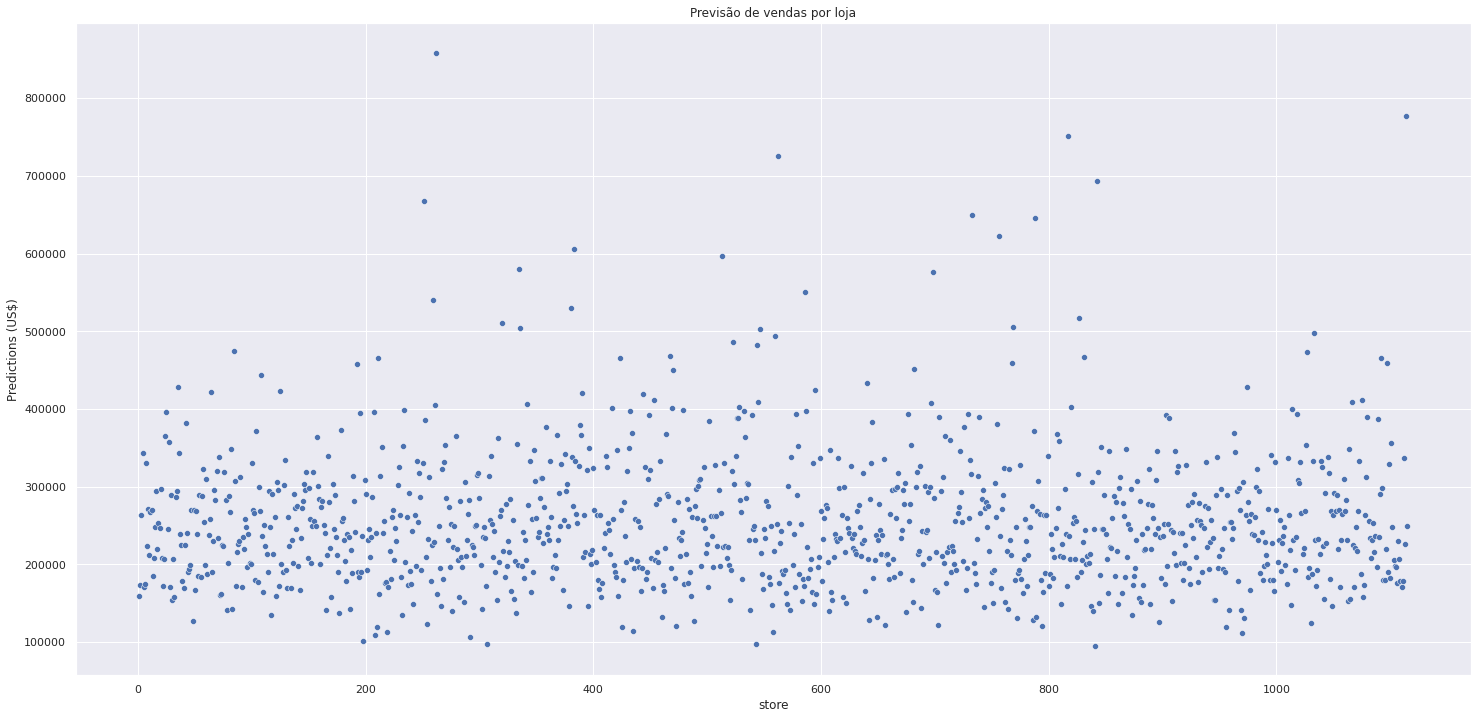

In [73]:
sns.scatterplot(x='store', y='predictions', data = df9_2)
plt.title("Previsão de vendas por loja")
plt.ylabel("Predictions (US$)");

Text(0.5, 1.0, 'Lojas x Erro RMSE')

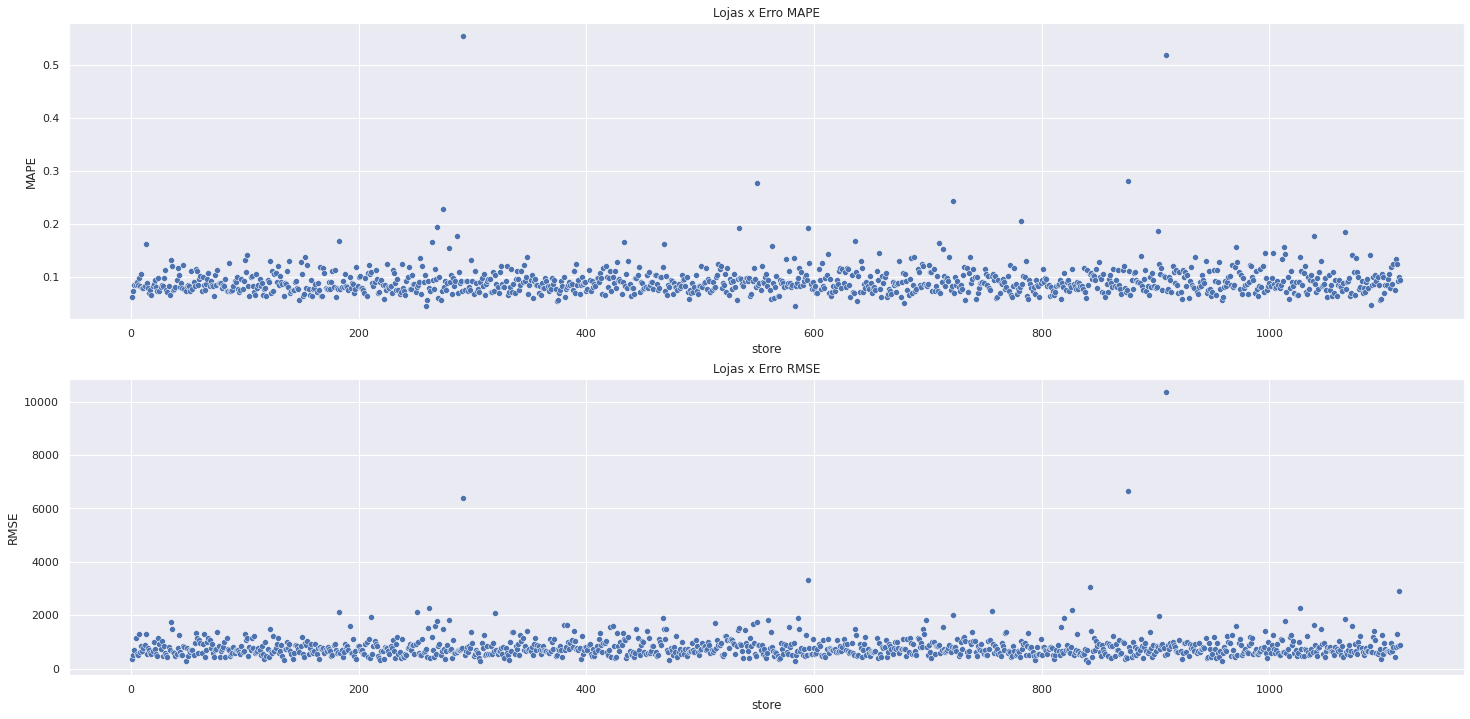

In [68]:
plt.subplot(2,1,1)
sns.scatterplot(x='store', y='MAPE', data = df9_2)
plt.title("Lojas x Erro MAPE")
plt.subplot(2,1,2)
sns.scatterplot(x='store', y='RMSE', data = df9_auxRMSE)
plt.title("Lojas x Erro RMSE")

### 8.2 Performance Total

In [74]:
df9_3 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns= {'index': 'Scenario', 0: 'Values' })
df9_3['Values'] = df9_3['Values'].map('R${:,.2f}'.format)
df9_3

,Scenario,Values
0,predictions,"R$283,881,088.00"
1,worst_scenario,"R$283,178,826.98"
2,best_scenario,"R$284,583,373.63"


### 8.3 Performance do modelo 

In [69]:
df9['error'] = df9['sales']-df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [70]:
df9['date'] = df_teste['date']

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Dispersão dos erros')

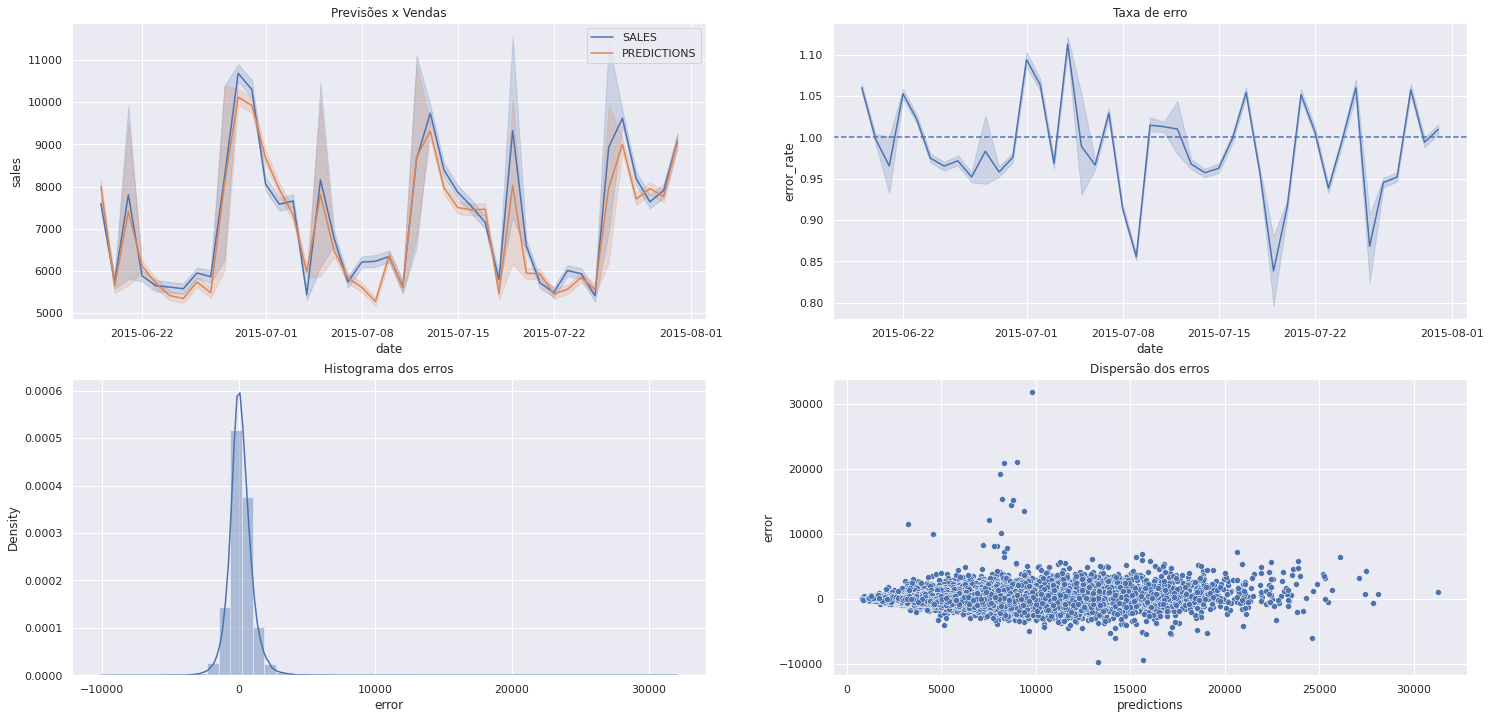

In [71]:
plt.subplot(2,2,1)
sns.lineplot(x = 'date', y='sales', data=df9, label='SALES')
sns.lineplot(x = 'date', y='predictions', data=df9, label='PREDICTIONS')
plt.title('Previsões x Vendas')


plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.title('Taxa de erro')
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])
plt.title('Histograma dos erros')

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])
plt.title('Dispersão dos erros')

---
# 10.0 Deploy do modelo em Produção

In [ ]:
#Para entender como foi feito o deploy do modelo, visite meu portfolio: https://henriquelucasdf.github.io/post/projeto1/

In [ ]:
#Os dados estão todos disponíveis no repositório a seguir: https://github.com/henriquelucasdf/Previsao_vendas_rossmann